# Import Libraries

In [2]:
from datetime import datetime, timedelta
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from __future__ import division

#import chart_studio.plotly as py
#import plotly.offline as pyoff
#import plotly.graph_objs as go

from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import iqr
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import sklearn as sk
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import StackingClassifier
#inititate Plotly
#pyoff.init_notebook_mode()

# Load Uplift_Modelling.xlsx

In [2]:
tx_data = pd.read_csv('Sample Data.csv')
tx_data

zip5  unique_key   age channel_cd state  cancels_month treatment  resp  \
0     98208           1  32.0         DM    WA             22        HO     0   
1     70816           2  32.0         DM    LA             13        HO     0   
2     89128           3  30.0         DM    NV              6        HO     0   
3     36532           4   NaN         DM    AL              6        HO     0   
4     70065           5  29.0      DM_EM    LA             18        HO     0   
...     ...         ...   ...        ...   ...            ...       ...   ...   
9995  98036        9996  82.0         DM    WA             18        HO     1   
9996  32757        9997  74.0      DM_EM    FL              7        HO     1   
9997  28216        9998   NaN      DM_EM    NC              7        HO     1   
9998  27909        9999   NaN         DM    NC             18        HO     1   
9999  95966       10000   NaN         DM    CA             22        HO     1   

      conv region            division                 cancel_reason_bucket  \
0        0   West             Pacific                          Non-Payment   
1        0  South  West_South_Central                          Non-Payment   
2        0   West            Mountain  Sold car/Inoperable/Not running (Y)   
3        0  South  East_South_Central  Sold car/Inoperable/Not running (Y)   
4        0  South  West_South_Central                    Other Company (Y)   
...    ...    ...                 ...                                  ...   
9995     1   West             Pacific             Rate dissatisfaction (Y)   
9996     1  South      South_Atlantic                          Non-Payment   
9997     1  South      South_Atlantic                          Non-Payment   
9998     1  South      South_Atlantic                          Non-Payment   
9999     0   West             Pacific             Rate dissatisfaction (Y)   

      annual_premium_select  driver_cnt_select  vehicle_cnt_select  polk_flag  \
0                     934.0                1.0                 1.0          1   
1                    1855.0                1.0                 1.0          1   
2                     750.0                1.0                 1.0          1   
3                     549.0                1.0                 1.0          1   
4                    2110.0                1.0                 1.0          1   
...                     ...                ...                 ...        ...   
9995                  777.0                2.0                 2.0          1   
9996                  988.0                2.0                 1.0          1   
9997                  373.0                1.0                 1.0          1   
9998                  372.0                1.0                 3.0          1   
9999                 1403.0                2.0                 2.0          1   

     pif_own_rent_cd internet_sale_ind pif_risk_lvl  
0                  T                 N            D  
1                  T                 N            C  
2                  T                 N            B  
3                  T                 N            C  
4                  T                 N            D  
...              ...               ...          ...  
9995             NaN               NaN          NaN  
9996               O                 N            C  
9997             NaN               NaN          NaN  
9998               O                 Y            B  
9999               O                 Y            B  

[10000 rows x 19 columns]

# Get dataset info, Null values in each column & Description

In [3]:
tx_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   zip5                   10000 non-null  int64  
 1   unique_key             10000 non-null  int64  
 2   age                    6959 non-null   float64
 3   channel_cd             10000 non-null  object 
 4   state                  10000 non-null  object 
 5   cancels_month          10000 non-null  int64  
 6   treatment              10000 non-null  object 
 7   resp                   10000 non-null  int64  
 8   conv                   10000 non-null  int64  
 9   region                 10000 non-null  object 
 10  division               10000 non-null  object 
 11  cancel_reason_bucket   10000 non-null  object 
 12  annual_premium_select  9581 non-null   float64
 13  driver_cnt_select      9581 non-null   float64
 14  vehicle_cnt_select     9581 non-null   float64
 15  pol

In [4]:
tx_data.isnull().sum()

zip5                        0
unique_key                  0
age                      3041
channel_cd                  0
state                       0
cancels_month               0
treatment                   0
resp                        0
conv                        0
region                      0
division                    0
cancel_reason_bucket        0
annual_premium_select     419
driver_cnt_select         419
vehicle_cnt_select        419
polk_flag                   0
pif_own_rent_cd           600
internet_sale_ind         465
pif_risk_lvl              465
dtype: int64

In [5]:
tx_data.describe()

zip5   unique_key          age  cancels_month          resp  \
count  10000.000000  10000.00000  6959.000000   10000.000000  10000.000000   
mean   48894.288000   5000.50000    42.776261      13.259600      0.200100   
std    29339.191558   2886.89568    15.033663       6.238036      0.400095   
min     1020.000000      1.00000    19.000000       4.000000      0.000000   
25%    25314.000000   2500.75000    31.000000       7.000000      0.000000   
50%    39849.500000   5000.50000    39.000000      13.000000      0.000000   
75%    77087.250000   7500.25000    53.000000      19.000000      0.000000   
max    99709.000000  10000.00000   103.000000      24.000000      1.000000   

               conv  annual_premium_select  driver_cnt_select  \
count  10000.000000            9581.000000        9581.000000   
mean       0.067500            1183.470932           1.729047   
std        0.250898             846.779226           0.926788   
min        0.000000              32.000000           1.000000   
25%        0.000000             626.000000           1.000000   
50%        0.000000             968.000000           2.000000   
75%        0.000000            1501.000000           2.000000   
max        1.000000           10552.000000           9.000000   

       vehicle_cnt_select     polk_flag  
count         9581.000000  10000.000000  
mean             1.439098      0.970000  
std              0.771877      0.170596  
min              1.000000      0.000000  
25%              1.000000      1.000000  
50%              1.000000      1.000000  
75%              2.000000      1.000000  
max              9.000000      1.000000

# Divide into HO and Promo

In [6]:
df_HO = tx_data[tx_data.treatment == 'HO']
df_Promo = tx_data[tx_data.treatment == 'Promo']

In [7]:
df_HO

zip5  unique_key   age channel_cd state  cancels_month treatment  resp  \
0     98208           1  32.0         DM    WA             22        HO     0   
1     70816           2  32.0         DM    LA             13        HO     0   
2     89128           3  30.0         DM    NV              6        HO     0   
3     36532           4   NaN         DM    AL              6        HO     0   
4     70065           5  29.0      DM_EM    LA             18        HO     0   
...     ...         ...   ...        ...   ...            ...       ...   ...   
9995  98036        9996  82.0         DM    WA             18        HO     1   
9996  32757        9997  74.0      DM_EM    FL              7        HO     1   
9997  28216        9998   NaN      DM_EM    NC              7        HO     1   
9998  27909        9999   NaN         DM    NC             18        HO     1   
9999  95966       10000   NaN         DM    CA             22        HO     1   

      conv region            division                 cancel_reason_bucket  \
0        0   West             Pacific                          Non-Payment   
1        0  South  West_South_Central                          Non-Payment   
2        0   West            Mountain  Sold car/Inoperable/Not running (Y)   
3        0  South  East_South_Central  Sold car/Inoperable/Not running (Y)   
4        0  South  West_South_Central                    Other Company (Y)   
...    ...    ...                 ...                                  ...   
9995     1   West             Pacific             Rate dissatisfaction (Y)   
9996     1  South      South_Atlantic                          Non-Payment   
9997     1  South      South_Atlantic                          Non-Payment   
9998     1  South      South_Atlantic                          Non-Payment   
9999     0   West             Pacific             Rate dissatisfaction (Y)   

      annual_premium_select  driver_cnt_select  vehicle_cnt_select  polk_flag  \
0                     934.0                1.0                 1.0          1   
1                    1855.0                1.0                 1.0          1   
2                     750.0                1.0                 1.0          1   
3                     549.0                1.0                 1.0          1   
4                    2110.0                1.0                 1.0          1   
...                     ...                ...                 ...        ...   
9995                  777.0                2.0                 2.0          1   
9996                  988.0                2.0                 1.0          1   
9997                  373.0                1.0                 1.0          1   
9998                  372.0                1.0                 3.0          1   
9999                 1403.0                2.0                 2.0          1   

     pif_own_rent_cd internet_sale_ind pif_risk_lvl  
0                  T                 N            D  
1                  T                 N            C  
2                  T                 N            B  
3                  T                 N            C  
4                  T                 N            D  
...              ...               ...          ...  
9995             NaN               NaN          NaN  
9996               O                 N            C  
9997             NaN               NaN          NaN  
9998               O                 Y            B  
9999               O                 Y            B  

[5000 rows x 19 columns]

In [8]:
df_Promo

zip5  unique_key   age channel_cd state  cancels_month treatment  resp  \
4000  72712        4001   NaN      DM_EM    AR              7     Promo     0   
4001  98248        4002  30.0         DM    WA             13     Promo     0   
4002  89108        4003  35.0      DM_EM    NV             12     Promo     0   
4003  99202        4004  61.0         DM    WA             19     Promo     0   
4004  98034        4005  53.0         DM    WA             22     Promo     0   
...     ...         ...   ...        ...   ...            ...       ...   ...   
8995  64080        8996  53.0         DM    MO             19     Promo     1   
8996  77083        8997  56.0      DM_EM    TX             12     Promo     1   
8997  77488        8998  26.0      DM_EM    TX             20     Promo     1   
8998  77016        8999   NaN         DM    TX              6     Promo     1   
8999  32771        9000  50.0      DM_EM    FL             11     Promo     1   

      conv   region            division                 cancel_reason_bucket  \
4000     0    South  West_South_Central                    Other Company (Y)   
4001     0     West             Pacific  Sold car/Inoperable/Not running (Y)   
4002     0     West            Mountain                  No reason given (Y)   
4003     0     West             Pacific                    Other Company (Y)   
4004     0     West             Pacific                          Non-Payment   
...    ...      ...                 ...                                  ...   
8995     0  Midwest  West_North_Central                          Non-Payment   
8996     0    South  West_South_Central                          Non-Payment   
8997     1    South  West_South_Central                          Non-Payment   
8998     0    South  West_South_Central                          Non-Payment   
8999     0    South      South_Atlantic                    Other Company (Y)   

      annual_premium_select  driver_cnt_select  vehicle_cnt_select  polk_flag  \
4000                  579.0                2.0                 1.0          1   
4001                 1999.0                1.0                 1.0          1   
4002                 1495.0                2.0                 1.0          1   
4003                  636.0                1.0                 1.0          1   
4004                  309.0                1.0                 1.0          1   
...                     ...                ...                 ...        ...   
8995                 2045.0                3.0                 1.0          1   
8996                 1684.0                2.0                 2.0          1   
8997                 1542.0                1.0                 1.0          1   
8998                 1360.0                1.0                 1.0          1   
8999                 6687.0                5.0                 3.0          1   

     pif_own_rent_cd internet_sale_ind pif_risk_lvl  
4000               T                 N            B  
4001             NaN               NaN          NaN  
4002               T                 N            C  
4003               T                 N            D  
4004               T                 N            B  
...              ...               ...          ...  
8995               T                 N            D  
8996               T                 Y            B  
8997               O                 Y            D  
8998               T                 Y            B  
8999               O                 Y            B  

[5000 rows x 19 columns]

# Consider states AZ, CA, FL, GA, IL, MA, MD, NC, NY, OH, PA, TX, VA and make rest of the states as 'other'

In [9]:
#lst = ['AZ', 'CA', 'FL', 'GA', 'IL', 'MA', 'MD', 'NC', 'NY', 'OH', 'PA', 'TX', 'VA']
#tx_data = tx_data[tx_data.state.isin(lst)]

def oth(tx_data):
    if(tx_data['state'] != 'AZ' and
       tx_data['state'] != 'CA' and
       tx_data['state'] != 'FL' and
       tx_data['state'] != 'GA' and
       tx_data['state'] != 'IL' and
       tx_data['state'] != 'MA' and
       tx_data['state'] != 'MD' and
       tx_data['state'] != 'NC' and
       tx_data['state'] != 'NY' and
       tx_data['state'] != 'OH' and
       tx_data['state'] != 'PA' and
       tx_data['state'] != 'TX' and
       tx_data['state'] != 'VA'):
        return 'Other'
    else:
        return tx_data['state']
tx_data['state'] = tx_data.apply(oth, axis=1)

tx_data

zip5  unique_key   age channel_cd  state  cancels_month treatment  \
0     98208           1  32.0         DM  Other             22        HO   
1     70816           2  32.0         DM  Other             13        HO   
2     89128           3  30.0         DM  Other              6        HO   
3     36532           4   NaN         DM  Other              6        HO   
4     70065           5  29.0      DM_EM  Other             18        HO   
...     ...         ...   ...        ...    ...            ...       ...   
9995  98036        9996  82.0         DM  Other             18        HO   
9996  32757        9997  74.0      DM_EM     FL              7        HO   
9997  28216        9998   NaN      DM_EM     NC              7        HO   
9998  27909        9999   NaN         DM     NC             18        HO   
9999  95966       10000   NaN         DM     CA             22        HO   

      resp  conv region            division  \
0        0     0   West             Pacific   
1        0     0  South  West_South_Central   
2        0     0   West            Mountain   
3        0     0  South  East_South_Central   
4        0     0  South  West_South_Central   
...    ...   ...    ...                 ...   
9995     1     1   West             Pacific   
9996     1     1  South      South_Atlantic   
9997     1     1  South      South_Atlantic   
9998     1     1  South      South_Atlantic   
9999     1     0   West             Pacific   

                     cancel_reason_bucket  annual_premium_select  \
0                             Non-Payment                  934.0   
1                             Non-Payment                 1855.0   
2     Sold car/Inoperable/Not running (Y)                  750.0   
3     Sold car/Inoperable/Not running (Y)                  549.0   
4                       Other Company (Y)                 2110.0   
...                                   ...                    ...   
9995             Rate dissatisfaction (Y)                  777.0   
9996                          Non-Payment                  988.0   
9997                          Non-Payment                  373.0   
9998                          Non-Payment                  372.0   
9999             Rate dissatisfaction (Y)                 1403.0   

      driver_cnt_select  vehicle_cnt_select  polk_flag pif_own_rent_cd  \
0                   1.0                 1.0          1               T   
1                   1.0                 1.0          1               T   
2                   1.0                 1.0          1               T   
3                   1.0                 1.0          1               T   
4                   1.0                 1.0          1               T   
...                 ...                 ...        ...             ...   
9995                2.0                 2.0          1             NaN   
9996                2.0                 1.0          1               O   
9997                1.0                 1.0          1             NaN   
9998                1.0                 3.0          1               O   
9999                2.0                 2.0          1               O   

     internet_sale_ind pif_risk_lvl  
0                    N            D  
1                    N            C  
2                    N            B  
3                    N            C  
4                    N            D  
...                ...          ...  
9995               NaN          NaN  
9996                 N            C  
9997               NaN          NaN  
9998                 Y            B  
9999                 Y            B  

[10000 rows x 19 columns]

# @ Get counts of treatment variables

In [10]:
tx_data['treatment'].value_counts()

HO       5000
Promo    5000
Name: treatment, dtype: int64

#### There is a 50-50 split. 

## Encode treament variable as 0/1
#### 0 = HO (Control Group)
#### 1 = Promo (Test Group) 

In [11]:
tx_data['treatment'] = tx_data['treatment'].map(arg={'HO': 0, 'Promo': 1})

# @ Get count of channel_cd variables

In [12]:
tx_data['channel_cd'].value_counts()

DM       7506
DM_EM    2494
Name: channel_cd, dtype: int64

## Encode channel_cd variable as 0/1
#### 0 = DM (Direct mail)
#### 1 = DM_EM (Direct mail & email)

In [13]:
tx_data['channel_cd'] = tx_data['channel_cd'].map(arg={'DM': 0, 'DM_EM': 1})

# @ Get count of cancel_reason_bucket

In [14]:
tx_data['cancel_reason_bucket'].value_counts()

Non-Payment                            3606
Other Company (Y)                      3175
Rate dissatisfaction (Y)               1717
Sold car/Inoperable/Not running (Y)     694
No reason given (Y)                     488
Others                                  320
Name: cancel_reason_bucket, dtype: int64

###### Below method of encoding (Label Encoding) is not an effectve method. It wouldn't make sense to say that one category  is greater or smaller than the other category.

## Encode cancel_reason_bucket as 0/1/2/3/4/5
#### 0 = Non-Payment
#### 1 = Other Company (Y)
#### 2 = Rate dissatisfaction (Y)
#### 3 = Sold car/Inoperable/Not running (Y)
#### 4 = No reason given (Y)
#### 5 = Others
## Create new column cancel_reason_flag

## One hot encoding on region - Better approach than Label Encoding

In [15]:
y_cancel_reason_bucket = pd.get_dummies(tx_data.cancel_reason_bucket, prefix='cancel_reason')
y_cancel_reason_bucket

cancel_reason_No reason given (Y)  cancel_reason_Non-Payment  \
0                                     0                          1   
1                                     0                          1   
2                                     0                          0   
3                                     0                          0   
4                                     0                          0   
...                                 ...                        ...   
9995                                  0                          0   
9996                                  0                          1   
9997                                  0                          1   
9998                                  0                          1   
9999                                  0                          0   

      cancel_reason_Other Company (Y)  cancel_reason_Others  \
0                                   0                     0   
1                                   0                     0   
2                                   0                     0   
3                                   0                     0   
4                                   1                     0   
...                               ...                   ...   
9995                                0                     0   
9996                                0                     0   
9997                                0                     0   
9998                                0                     0   
9999                                0                     0   

      cancel_reason_Rate dissatisfaction (Y)  \
0                                          0   
1                                          0   
2                                          0   
3                                          0   
4                                          0   
...                                      ...   
9995                                       1   
9996                                       0   
9997                                       0   
9998                                       0   
9999                                       1   

      cancel_reason_Sold car/Inoperable/Not running (Y)  
0                                                     0  
1                                                     0  
2                                                     1  
3                                                     1  
4                                                     0  
...                                                 ...  
9995                                                  0  
9996                                                  0  
9997                                                  0  
9998                                                  0  
9999                                                  0  

[10000 rows x 6 columns]

# @ Get count of state

In [16]:
tx_data['state'].value_counts()

Other    3665
TX       1237
FL       1122
NY        623
CA        587
OH        387
GA        386
VA        347
PA        316
AZ        312
IL        292
MD        277
NC        264
MA        185
Name: state, dtype: int64

## One hot encoding on state

In [17]:
y_state = pd.get_dummies(tx_data.state, prefix='State')
y_state

State_AZ  State_CA  State_FL  State_GA  State_IL  State_MA  State_MD  \
0            0         0         0         0         0         0         0   
1            0         0         0         0         0         0         0   
2            0         0         0         0         0         0         0   
3            0         0         0         0         0         0         0   
4            0         0         0         0         0         0         0   
...        ...       ...       ...       ...       ...       ...       ...   
9995         0         0         0         0         0         0         0   
9996         0         0         1         0         0         0         0   
9997         0         0         0         0         0         0         0   
9998         0         0         0         0         0         0         0   
9999         0         1         0         0         0         0         0   

      State_NC  State_NY  State_OH  State_Other  State_PA  State_TX  State_VA  
0            0         0         0            1         0         0         0  
1            0         0         0            1         0         0         0  
2            0         0         0            1         0         0         0  
3            0         0         0            1         0         0         0  
4            0         0         0            1         0         0         0  
...        ...       ...       ...          ...       ...       ...       ...  
9995         0         0         0            1         0         0         0  
9996         0         0         0            0         0         0         0  
9997         1         0         0            0         0         0         0  
9998         1         0         0            0         0         0         0  
9999         0         0         0            0         0         0         0  

[10000 rows x 14 columns]

# @ Get count of region

In [18]:
tx_data['region'].value_counts()

South        4917
West         1906
Northeast    1764
Midwest      1413
Name: region, dtype: int64

## One hot encoding on region

In [19]:
y_region = pd.get_dummies(tx_data.region, prefix='Region')
y_region

Region_Midwest  Region_Northeast  Region_South  Region_West
0                  0                 0             0            1
1                  0                 0             1            0
2                  0                 0             0            1
3                  0                 0             1            0
4                  0                 0             1            0
...              ...               ...           ...          ...
9995               0                 0             0            1
9996               0                 0             1            0
9997               0                 0             1            0
9998               0                 0             1            0
9999               0                 0             0            1

[10000 rows x 4 columns]

# @ Get count of division

In [20]:
tx_data['division'].value_counts()

South_Atlantic        2759
West_South_Central    1580
Middle_Atlantic       1259
Pacific               1037
East_North_Central     912
Mountain               869
East_South_Central     578
New_England            505
West_North_Central     501
Name: division, dtype: int64

## One hot encoding on division

In [21]:
y_division = pd.get_dummies(tx_data.division, prefix='Division')
y_division

Division_East_North_Central  Division_East_South_Central  \
0                               0                            0   
1                               0                            0   
2                               0                            0   
3                               0                            1   
4                               0                            0   
...                           ...                          ...   
9995                            0                            0   
9996                            0                            0   
9997                            0                            0   
9998                            0                            0   
9999                            0                            0   

      Division_Middle_Atlantic  Division_Mountain  Division_New_England  \
0                            0                  0                     0   
1                            0                  0                     0   
2                            0                  1                     0   
3                            0                  0                     0   
4                            0                  0                     0   
...                        ...                ...                   ...   
9995                         0                  0                     0   
9996                         0                  0                     0   
9997                         0                  0                     0   
9998                         0                  0                     0   
9999                         0                  0                     0   

      Division_Pacific  Division_South_Atlantic  Division_West_North_Central  \
0                    1                        0                            0   
1                    0                        0                            0   
2                    0                        0                            0   
3                    0                        0                            0   
4                    0                        0                            0   
...                ...                      ...                          ...   
9995                 1                        0                            0   
9996                 0                        1                            0   
9997                 0                        1                            0   
9998                 0                        1                            0   
9999                 1                        0                            0   

      Division_West_South_Central  
0                               0  
1                               1  
2                               0  
3                               0  
4                               1  
...                           ...  
9995                            0  
9996                            0  
9997                            0  
9998                            0  
9999                            0  

[10000 rows x 9 columns]

# @ Get count of pif_own_rent_cd

In [22]:
tx_data['pif_own_rent_cd'].value_counts()

T    6076
O    3035
R     289
Name: pif_own_rent_cd, dtype: int64

In [23]:
y_pif_own_rent_cd = pd.get_dummies(tx_data.pif_own_rent_cd, prefix='Pif_own_rent_cd')
y_pif_own_rent_cd

Pif_own_rent_cd_O  Pif_own_rent_cd_R  Pif_own_rent_cd_T
0                     0                  0                  1
1                     0                  0                  1
2                     0                  0                  1
3                     0                  0                  1
4                     0                  0                  1
...                 ...                ...                ...
9995                  0                  0                  0
9996                  1                  0                  0
9997                  0                  0                  0
9998                  1                  0                  0
9999                  1                  0                  0

[10000 rows x 3 columns]

# @ Get count of internet_sale_ind

In [24]:
tx_data['internet_sale_ind'].value_counts()

Y    6311
N    3224
Name: internet_sale_ind, dtype: int64

In [25]:
y_internet_sale_ind = pd.get_dummies(tx_data.internet_sale_ind, prefix='internet_sale_ind')

# @ Get count of pif_risk_lvl

In [26]:
tx_data['pif_risk_lvl'].value_counts()

B    4691
C    3204
D    1640
Name: pif_risk_lvl, dtype: int64

In [27]:
y_pif_risk_lvl = pd.get_dummies(tx_data.pif_risk_lvl, prefix='Pif_risk_lvl')
y_pif_risk_lvl

Pif_risk_lvl_B  Pif_risk_lvl_C  Pif_risk_lvl_D
0                  0               0               1
1                  0               1               0
2                  1               0               0
3                  0               1               0
4                  0               0               1
...              ...             ...             ...
9995               0               0               0
9996               0               1               0
9997               0               0               0
9998               1               0               0
9999               1               0               0

[10000 rows x 3 columns]

In [28]:
# Doubt: Whats the use of driver & vehicle counts?
# insurance company

In [29]:
# 16,17,18 correlation
# 13,14 correlation

# Concatenate columnns by column 

In [30]:
tx_data = pd.concat([tx_data, y_state, y_region, y_division, y_cancel_reason_bucket, y_pif_own_rent_cd,y_internet_sale_ind, y_pif_risk_lvl], axis=1)
tx_data

zip5  unique_key   age  channel_cd  state  cancels_month  treatment  \
0     98208           1  32.0           0  Other             22          0   
1     70816           2  32.0           0  Other             13          0   
2     89128           3  30.0           0  Other              6          0   
3     36532           4   NaN           0  Other              6          0   
4     70065           5  29.0           1  Other             18          0   
...     ...         ...   ...         ...    ...            ...        ...   
9995  98036        9996  82.0           0  Other             18          0   
9996  32757        9997  74.0           1     FL              7          0   
9997  28216        9998   NaN           1     NC              7          0   
9998  27909        9999   NaN           0     NC             18          0   
9999  95966       10000   NaN           0     CA             22          0   

      resp  conv region  ... cancel_reason_Rate dissatisfaction (Y)  \
0        0     0   West  ...                                      0   
1        0     0  South  ...                                      0   
2        0     0   West  ...                                      0   
3        0     0  South  ...                                      0   
4        0     0  South  ...                                      0   
...    ...   ...    ...  ...                                    ...   
9995     1     1   West  ...                                      1   
9996     1     1  South  ...                                      0   
9997     1     1  South  ...                                      0   
9998     1     1  South  ...                                      0   
9999     1     0   West  ...                                      1   

     cancel_reason_Sold car/Inoperable/Not running (Y)  Pif_own_rent_cd_O  \
0                                                    0                  0   
1                                                    0                  0   
2                                                    1                  0   
3                                                    1                  0   
4                                                    0                  0   
...                                                ...                ...   
9995                                                 0                  0   
9996                                                 0                  1   
9997                                                 0                  0   
9998                                                 0                  1   
9999                                                 0                  1   

      Pif_own_rent_cd_R  Pif_own_rent_cd_T  internet_sale_ind_N  \
0                     0                  1                    1   
1                     0                  1                    1   
2                     0                  1                    1   
3                     0                  1                    1   
4                     0                  1                    1   
...                 ...                ...                  ...   
9995                  0                  0                    0   
9996                  0                  0                    1   
9997                  0                  0                    0   
9998                  0                  0                    0   
9999                  0                  0                    0   

     internet_sale_ind_Y Pif_risk_lvl_B Pif_risk_lvl_C  Pif_risk_lvl_D  
0                      0              0              0               1  
1                      0              0              1               0  
2                      0              1              0               0  
3                      0              0              1               0  
4                      0              0              0               1  
...                  ...            ...          

## Remove columns having string values (hot encoding for these columns is done). Also remove 'unique_key' and 'zip5' as there are too many distinct values and these wont have any correlation with any

In [31]:
tx_data = tx_data.drop(['zip5', 'unique_key', 'state', 'conv', 'division', 'region', 'cancel_reason_bucket', 'pif_own_rent_cd','internet_sale_ind', 'pif_risk_lvl'], axis=1)
tx_data

age  channel_cd  cancels_month  treatment  resp  annual_premium_select  \
0     32.0           0             22          0     0                  934.0   
1     32.0           0             13          0     0                 1855.0   
2     30.0           0              6          0     0                  750.0   
3      NaN           0              6          0     0                  549.0   
4     29.0           1             18          0     0                 2110.0   
...    ...         ...            ...        ...   ...                    ...   
9995  82.0           0             18          0     1                  777.0   
9996  74.0           1              7          0     1                  988.0   
9997   NaN           1              7          0     1                  373.0   
9998   NaN           0             18          0     1                  372.0   
9999   NaN           0             22          0     1                 1403.0   

      driver_cnt_select  vehicle_cnt_select  polk_flag  State_AZ  ...  \
0                   1.0                 1.0          1         0  ...   
1                   1.0                 1.0          1         0  ...   
2                   1.0                 1.0          1         0  ...   
3                   1.0                 1.0          1         0  ...   
4                   1.0                 1.0          1         0  ...   
...                 ...                 ...        ...       ...  ...   
9995                2.0                 2.0          1         0  ...   
9996                2.0                 1.0          1         0  ...   
9997                1.0                 1.0          1         0  ...   
9998                1.0                 3.0          1         0  ...   
9999                2.0                 2.0          1         0  ...   

      cancel_reason_Rate dissatisfaction (Y)  \
0                                          0   
1                                          0   
2                                          0   
3                                          0   
4                                          0   
...                                      ...   
9995                                       1   
9996                                       0   
9997                                       0   
9998                                       0   
9999                                       1   

      cancel_reason_Sold car/Inoperable/Not running (Y)  Pif_own_rent_cd_O  \
0                                                     0                  0   
1                                                     0                  0   
2                                                     1                  0   
3                                                     1                  0   
4                                                     0                  0   
...                                                 ...                ...   
9995                                                  0                  0   
9996                                                  0                  1   
9997                                                  0                  0   
9998                                                  0                  1   
9999                                                  0                  1   

      Pif_own_rent_cd_R  Pif_own_rent_cd_T  internet_sale_ind_N  \
0                     0                  1                    1   
1                     0                  1                    1   
2                     0                  1                    1   
3                     0                  1                    1   
4                     0                  1                    1   
...                 ...                ...                  ...   
9995                  0                  0                    0   
9996                  0                  0                    1   
9997                  0                 

In [32]:
print(tx_data['treatment'].value_counts())
print(tx_data['resp'].value_counts())
tx_data_1 = tx_data[tx_data.treatment == 1]
tx_data_0 = tx_data[tx_data.treatment == 0]
print(tx_data_1['resp'].value_counts())
print(tx_data_0['resp'].value_counts())

0    5000
1    5000
Name: treatment, dtype: int64
0    7999
1    2001
Name: resp, dtype: int64
0    3999
1    1001
Name: resp, dtype: int64
0    4000
1    1000
Name: resp, dtype: int64


In [33]:
exp_results_data = \
tx_data.groupby('treatment').agg({'resp':['mean', 'sum', 'count']})
exp_results_data

resp            
             mean   sum count
treatment                    
0          0.2000  1000  5000
1          0.2002  1001  5000

# Plot heatmap of feature correlation

In [34]:
# plt.figure(figsize = (120,80))
# sns.heatmap(tx_data.corr(), 
#             cmap='coolwarm',
#             cbar=False,
#             annot=True, 
#             fmt=".1f", 
#             annot_kws={'size':69})

In [35]:
from sklearn.model_selection import train_test_split
target = tx_data['resp']
features = tx_data.drop('resp', axis = 1)

#create the train/test split
data_X_train, X_val, data_y_train, y_val = train_test_split(features, target, test_size=0.20, random_state=9, shuffle=True)
val = pd.concat([X_val, y_val], axis=1, join='inner')
#val.dropna(inplace=True)
print(val['treatment'].value_counts())
print(y_val.value_counts())

0    1004
1     996
Name: treatment, dtype: int64
0    1591
1     409
Name: resp, dtype: int64


In [36]:
train_data = pd.concat([data_X_train, data_y_train], axis=1, join='inner')
#val.dropna(inplace=True)
train_data

age  channel_cd  cancels_month  treatment  annual_premium_select  \
9394  21.0           0              6          0                 2817.0   
50    23.0           1             14          0                 2329.0   
2884  54.0           0             12          0                  170.0   
1183  30.0           0             22          0                  631.0   
2077  71.0           0             16          0                  447.0   
...    ...         ...            ...        ...                    ...   
6200   NaN           0             22          1                  792.0   
501   28.0           0             15          0                  266.0   
6782   NaN           1              7          1                    NaN   
4444   NaN           0              5          1                  936.0   
8574  42.0           0             20          1                 1234.0   

      driver_cnt_select  vehicle_cnt_select  polk_flag  State_AZ  State_CA  \
9394                1.0                 2.0          1         0         0   
50                  1.0                 1.0          1         0         0   
2884                1.0                 1.0          1         0         1   
1183                1.0                 1.0          1         0         0   
2077                2.0                 1.0          1         0         0   
...                 ...                 ...        ...       ...       ...   
6200                1.0                 1.0          0         0         0   
501                 1.0                 1.0          1         0         0   
6782                NaN                 NaN          1         0         0   
4444                1.0                 1.0          1         0         0   
8574                1.0                 1.0          1         0         0   

      ...  cancel_reason_Sold car/Inoperable/Not running (Y)  \
9394  ...                                                  0   
50    ...                                                  0   
2884  ...                                                  1   
1183  ...                                                  1   
2077  ...                                                  0   
...   ...                                                ...   
6200  ...                                                  0   
501   ...                                                  1   
6782  ...                                                  0   
4444  ...                                                  0   
8574  ...                                                  1   

      Pif_own_rent_cd_O  Pif_own_rent_cd_R  Pif_own_rent_cd_T  \
9394                  0                  0                  1   
50                    0                  0                  1   
2884                  0                  0                  1   
1183                  0                  0                  1   
2077                  1                  0                  0   
...                 ...                ...                ...   
6200                  0                  0                  1   
501                   0                  0                  1   
6782                  0                  0                  1   
4444                  1                  0                  0   
8574                  0                  0                  1   

      internet_sale_ind_N  internet_sale_ind_Y  Pif_risk_lvl_B  \
9394                    0                    1               0   
50                      0                    1               0   
2884                    0                    1               1   
1183                    0                    1               0   
2077                    0                    1               1   
...                   ...                  ...             ...   
6200                    0                    1               0   
501                     0                    1               1   
6782                    0

In [37]:
val = pd.concat([X_val, y_val], axis=1, join='inner')
#val.dropna(inplace=True)
print(val['treatment'].value_counts())
print(val['resp'].value_counts())
val

0    1004
1     996
Name: treatment, dtype: int64
0    1591
1     409
Name: resp, dtype: int64


age  channel_cd  cancels_month  treatment  annual_premium_select  \
3644   NaN           1             23          0                 1126.0   
9184  24.0           1              7          0                  438.0   
520    NaN           0             19          0                  454.0   
5685   NaN           1             11          1                  696.0   
2401   NaN           0             21          0                 1045.0   
...    ...         ...            ...        ...                    ...   
6212   NaN           0             14          1                 2338.0   
9309   NaN           0             20          0                 2781.0   
7055  33.0           1             14          1                 1072.0   
4388  40.0           0             12          1                 3251.0   
3794   NaN           0             18          0                 2289.0   

      driver_cnt_select  vehicle_cnt_select  polk_flag  State_AZ  State_CA  \
3644                2.0                 2.0          1         0         1   
9184                1.0                 1.0          1         0         0   
520                 2.0                 1.0          1         0         0   
5685                1.0                 1.0          1         0         0   
2401                1.0                 1.0          1         0         0   
...                 ...                 ...        ...       ...       ...   
6212                6.0                 3.0          1         0         0   
9309                2.0                 1.0          1         0         0   
7055                2.0                 2.0          1         0         0   
4388                4.0                 4.0          1         0         0   
3794                1.0                 1.0          1         0         0   

      ...  cancel_reason_Sold car/Inoperable/Not running (Y)  \
3644  ...                                                  0   
9184  ...                                                  0   
520   ...                                                  1   
5685  ...                                                  1   
2401  ...                                                  0   
...   ...                                                ...   
6212  ...                                                  0   
9309  ...                                                  0   
7055  ...                                                  0   
4388  ...                                                  0   
3794  ...                                                  0   

      Pif_own_rent_cd_O  Pif_own_rent_cd_R  Pif_own_rent_cd_T  \
3644                  1                  0                  0   
9184                  0                  0                  0   
520                   0                  0                  1   
5685                  0                  0                  1   
2401                  1                  0                  0   
...                 ...                ...                ...   
6212                  0                  0                  1   
9309                  0                  0                  1   
7055                  0                  0                  1   
4388                  0                  0                  1   
3794                  0                  0                  1   

      internet_sale_ind_N  internet_sale_ind_Y  Pif_risk_lvl_B  \
3644                    0                    1               1   
9184                    0                    0               0   
520                     0                    1               0   
5685                    0                    1               1   
2401                    1                    0               1   
...                   ...                  ...             ...   
6212                    1                    0               1   
9309                    0                    1               0   
7055                    0

In [38]:
valid_0 = val[val.treatment == 0]
valid_1 = val[val.treatment == 1]
print(valid_0.shape)
print(valid_1.shape)
valid_0.head(20)

(1004, 50)
(996, 50)


age  channel_cd  cancels_month  treatment  annual_premium_select  \
3644   NaN           1             23          0                 1126.0   
9184  24.0           1              7          0                  438.0   
520    NaN           0             19          0                  454.0   
2401   NaN           0             21          0                 1045.0   
9853  43.0           0             18          0                  823.0   
49    46.0           0             22          0                  501.0   
9622  46.0           0             15          0                  559.0   
3111   NaN           0             14          0                  833.0   
3520  46.0           1             11          0                  677.0   
9701  63.0           0              6          0                  858.0   
1965  67.0           0              5          0                  646.0   
3621   NaN           0             23          0                 1526.0   
3446  27.0           0             12          0                 1607.0   
345   26.0           0              7          0                  781.0   
9978  47.0           0              7          0                    NaN   
562   29.0           0             23          0                  850.0   
2374  67.0           1             14          0                  380.0   
1700  52.0           0             21          0                  784.0   
3106  49.0           0              5          0                 1797.0   
2826  47.0           1              7          0                 1833.0   

      driver_cnt_select  vehicle_cnt_select  polk_flag  State_AZ  State_CA  \
3644                2.0                 2.0          1         0         1   
9184                1.0                 1.0          1         0         0   
520                 2.0                 1.0          1         0         0   
2401                1.0                 1.0          1         0         0   
9853                3.0                 1.0          1         0         0   
49                  1.0                 1.0          1         0         0   
9622                1.0                 1.0          1         0         0   
3111                1.0                 1.0          1         0         0   
3520                1.0                 1.0          1         0         0   
9701                1.0                 1.0          1         0         0   
1965                1.0                 1.0          1         0         0   
3621                2.0                 1.0          1         0         0   
3446                1.0                 1.0          1         0         0   
345                 2.0                 1.0          1         0         0   
9978                NaN                 NaN          1         0         0   
562                 2.0                 1.0          1         0         0   
2374                2.0                 1.0          1         0         0   
1700                2.0                 2.0          1         0         0   
3106                1.0                 1.0          1         0         0   
2826                1.0                 1.0          1         0         0   

      ...  cancel_reason_Sold car/Inoperable/Not running (Y)  \
3644  ...                                                  0   
9184  ...                                                  0   
520   ...                                                  1   
2401  ...                                                  0   
9853  ...                                                  0   
49    ...                                                  0   
9622  ...                                                  0   
3111  ...                                                  0   
3520  ...                                                  0   
9701  ...                                                  0   
1965  ...                                                  0   
3621  ...               

In [39]:
valid_0=valid_0.drop([valid_0.index[0],valid_0.index[2],valid_0.index[3],valid_0.index[5],valid_0.index[7],valid_0.index[8],valid_0.index[10],valid_0.index[11]])
val=pd.concat([valid_0,valid_1])
print(val['treatment'].value_counts())
print(val['resp'].value_counts())

0    996
1    996
Name: treatment, dtype: int64
0    1583
1     409
Name: resp, dtype: int64


In [40]:
print(val['treatment'].value_counts())
print(val['resp'].value_counts())
valdata_1 = val[val.treatment == 1]
valdata_0 = val[val.treatment == 0]
print(valdata_1['resp'].value_counts())
print(valdata_0['resp'].value_counts())

0    996
1    996
Name: treatment, dtype: int64
0    1583
1     409
Name: resp, dtype: int64
0    789
1    207
Name: resp, dtype: int64
0    794
1    202
Name: resp, dtype: int64


In [41]:
y_val = val['resp']
X_val = val.drop('resp', axis = 1)

# Feature Eng

<AxesSubplot:>

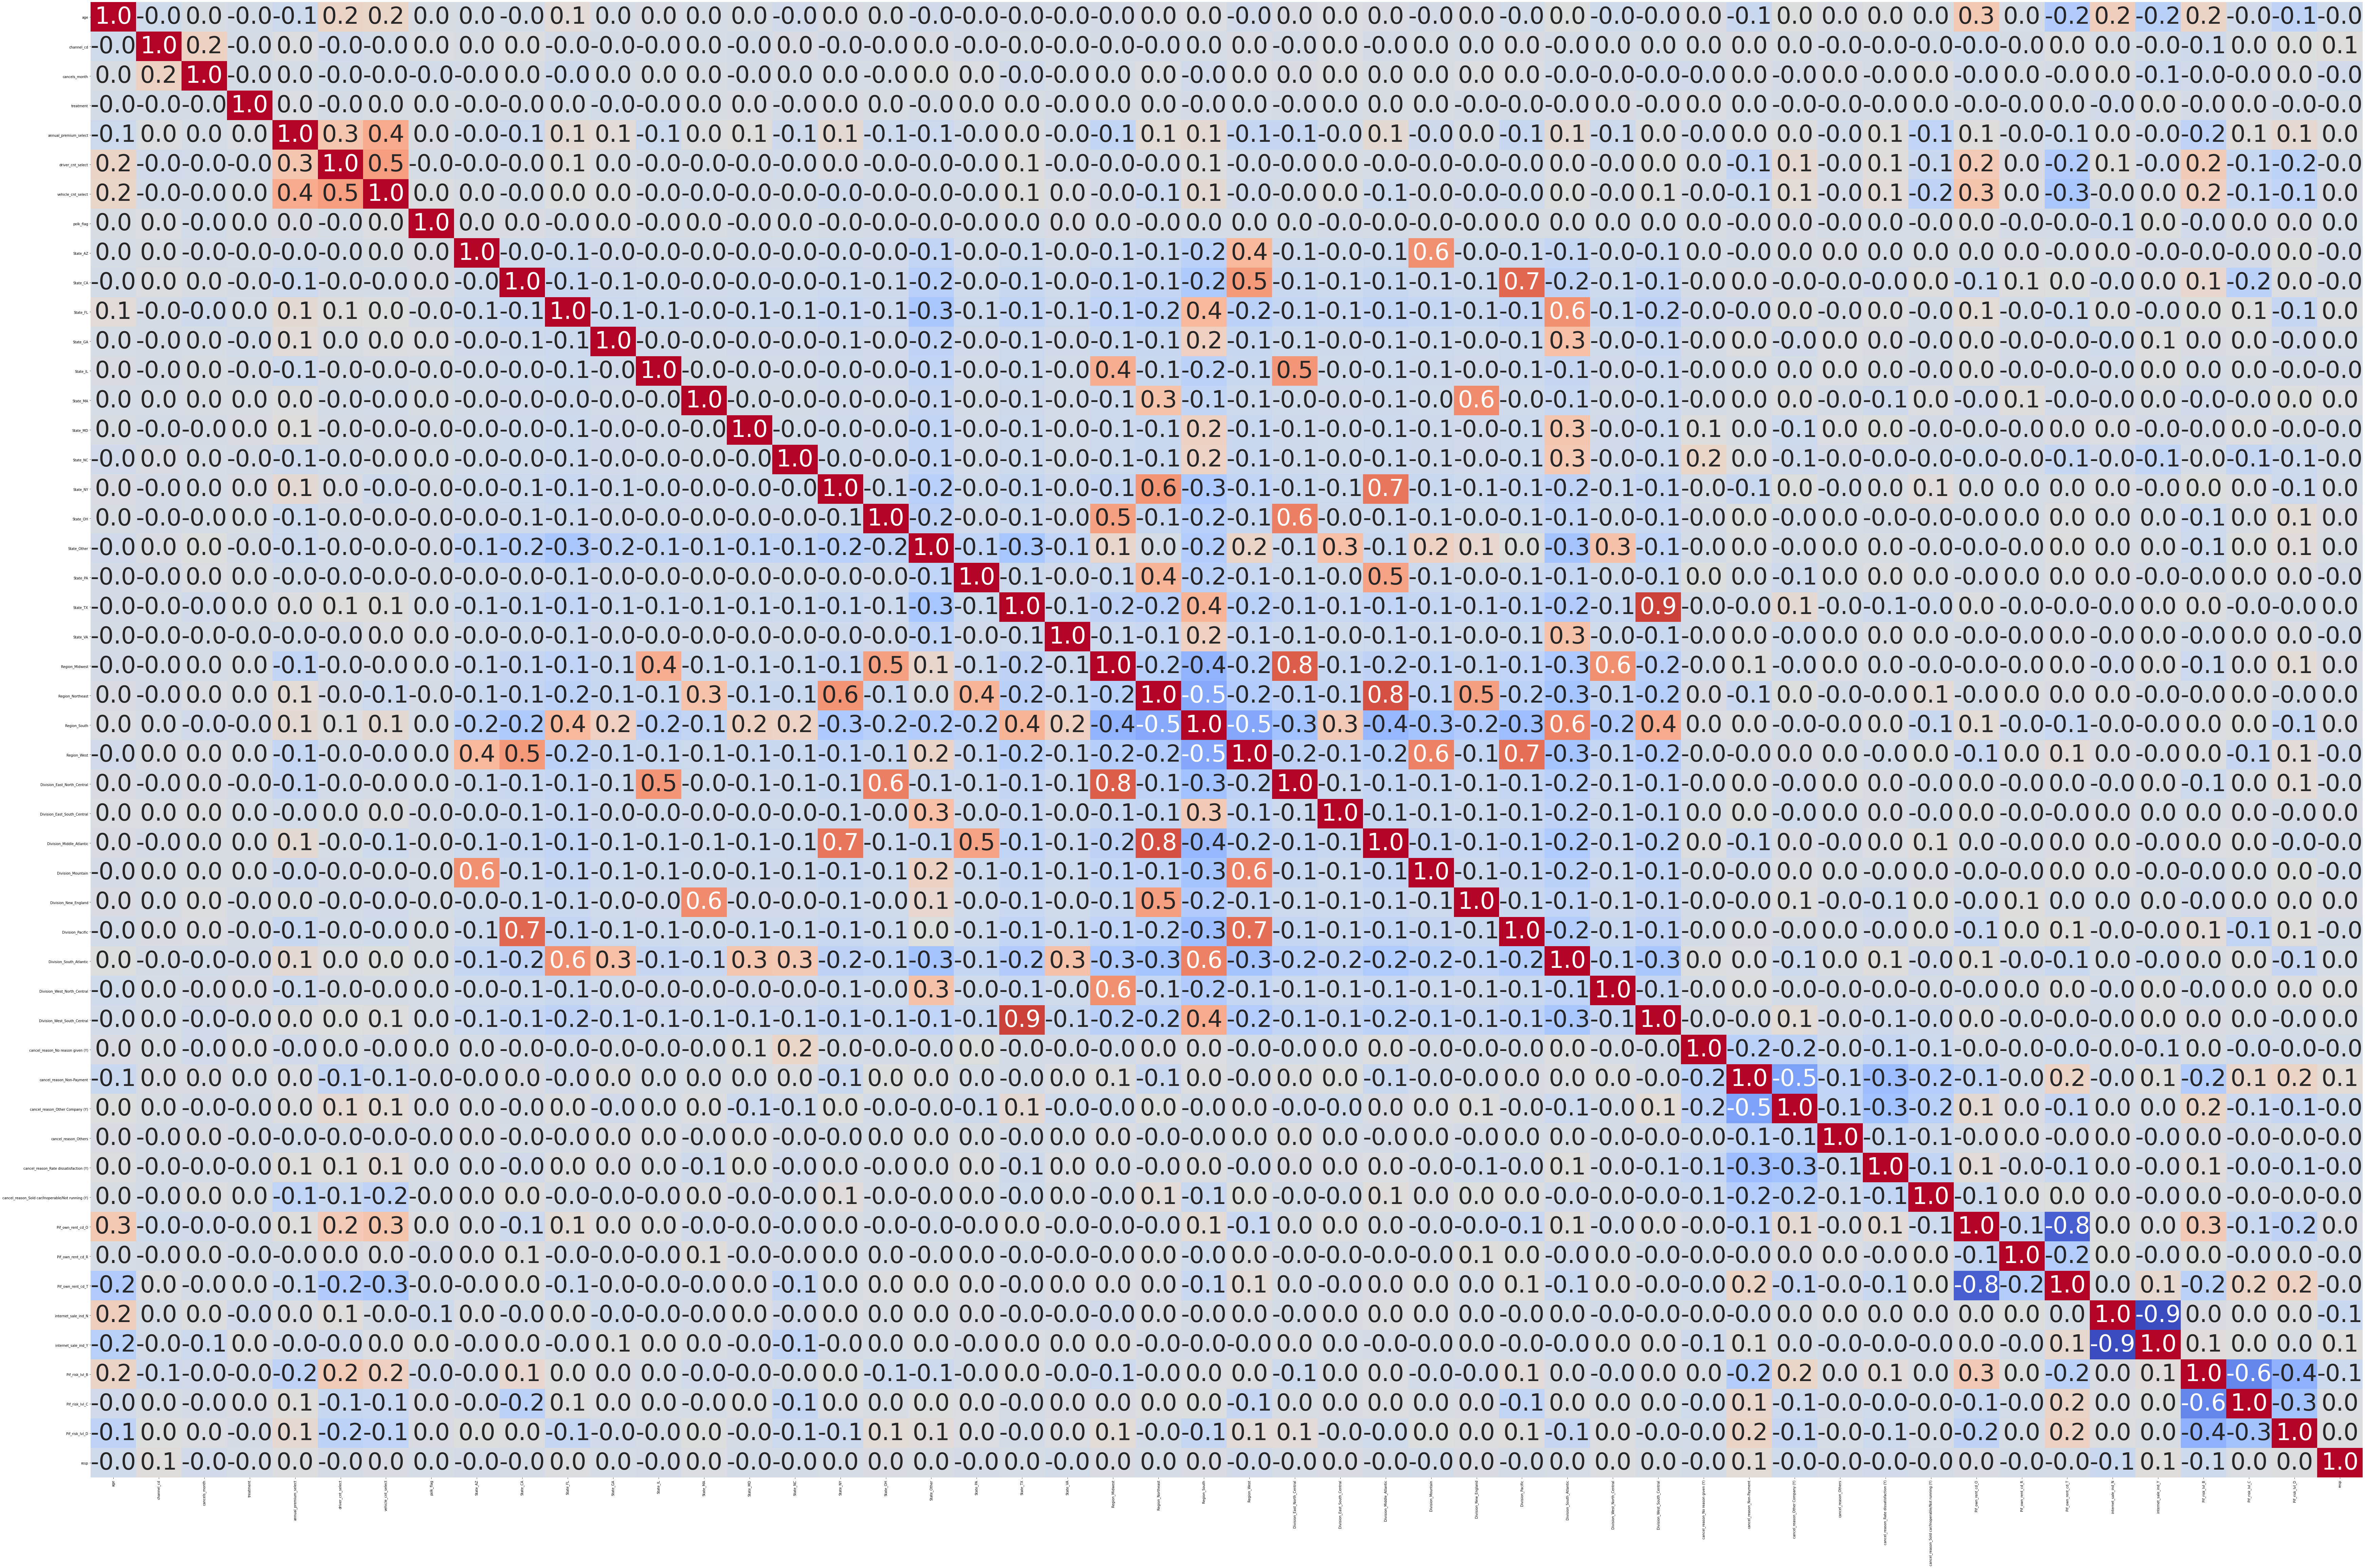

In [42]:
plt.figure(figsize = (120,80))
sns.heatmap(train_data.corr(), 
            cmap='coolwarm',
            cbar=False,
            annot=True, 
            fmt=".1f", 
            annot_kws={'size':69})

In [43]:

train_data = train_data.drop(['State_TX','Division_Middle_Atlantic','Division_East_North_Central'],axis=1)
data_y_train = train_data['resp']
data_X_train = train_data.drop('resp', axis = 1)
X_val = X_val.drop(['State_TX','Division_Middle_Atlantic','Division_East_North_Central'],axis=1)


#State_TX ,Division_West_South_Central ,,, Region_Midwest & Division_Middle_Atlantic,,,Region_Northeast& Division_East_North_Central

# Imputaions and outliers

In [44]:

from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors= 5)
imputed_X_train = pd.DataFrame(imputer.fit_transform(data_X_train))


In [45]:
imputed_X_train.columns = data_X_train.columns
imputed_X_train.shape
X_train_up = imputed_X_train.copy()
y_train_up = data_y_train.copy()
X_train_up
y_train_up

9394    1
50      0
2884    0
1183    0
2077    0
       ..
6200    0
501     0
6782    0
4444    0
8574    1
Name: resp, Length: 8000, dtype: int64

In [78]:
train_up = pd.concat([X_train_up, y_train_up], axis=1, join='inner')

In [46]:
# data_X_train.isnull().sum()

In [47]:
# for col in data_X_train:
#     a=plt.boxplot(data_X_train[col])
#     print(col)
#     plt.show(a)
# plt.boxplot(data_X_train['age'])
# (data_X_train['age']).value_counts()

In [1]:
outliers=["age", "annual_premium_select", "driver_cnt_select", "vehicle_cnt_select"]

In [49]:
for col in outliers:    
    out_age = data_X_train[col].quantile(0.75)+1.5*iqr(data_X_train[col])
    data_X_train[col]=data_X_train[col].mask(data_X_train[col]>out_age,out_age)

In [50]:
for col in data_X_train:
    a=plt.boxplot(data_X_train[col])
    print(col)
    plt.show(a)

In [51]:
-
X_val.isnull().sum()

age                                                  591
channel_cd                                             0
cancels_month                                          0
treatment                                              0
annual_premium_select                                 81
driver_cnt_select                                     81
vehicle_cnt_select                                    81
polk_flag                                              0
State_AZ                                               0
State_CA                                               0
State_FL                                               0
State_GA                                               0
State_IL                                               0
State_MA                                               0
State_MD                                               0
State_NC                                               0
State_NY                                               0
State_OH                       

In [52]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors= 5)
X_val_fea = pd.DataFrame(imputer.fit_transform(X_val))
X_val_fea.columns = X_train_up.columns
X_val_fea

age  channel_cd  cancels_month  treatment  annual_premium_select  \
0     24.0         1.0            7.0        0.0                  438.0   
1     43.0         0.0           18.0        0.0                  823.0   
2     46.0         0.0           15.0        0.0                  559.0   
3     63.0         0.0            6.0        0.0                  858.0   
4     27.0         0.0           12.0        0.0                 1607.0   
...    ...         ...            ...        ...                    ...   
1987  42.0         0.0           12.0        1.0                 1936.0   
1988  60.0         0.0           13.0        1.0                  280.0   
1989  40.4         0.0           14.0        1.0                 2338.0   
1990  33.0         1.0           14.0        1.0                 1072.0   
1991  40.0         0.0           12.0        1.0                 3251.0   

      driver_cnt_select  vehicle_cnt_select  polk_flag  State_AZ  State_CA  \
0                   1.0                 1.0        1.0       0.0       0.0   
1                   3.0                 1.0        1.0       0.0       0.0   
2                   1.0                 1.0        1.0       0.0       0.0   
3                   1.0                 1.0        1.0       0.0       0.0   
4                   1.0                 1.0        1.0       0.0       0.0   
...                 ...                 ...        ...       ...       ...   
1987                2.0                 2.0        1.0       0.0       0.0   
1988                1.0                 1.0        1.0       0.0       0.0   
1989                6.0                 3.0        1.0       0.0       0.0   
1990                2.0                 2.0        1.0       0.0       0.0   
1991                4.0                 4.0        1.0       0.0       0.0   

      ...  cancel_reason_Rate dissatisfaction (Y)  \
0     ...                                     0.0   
1     ...                                     1.0   
2     ...                                     0.0   
3     ...                                     1.0   
4     ...                                     0.0   
...   ...                                     ...   
1987  ...                                     0.0   
1988  ...                                     0.0   
1989  ...                                     1.0   
1990  ...                                     0.0   
1991  ...                                     1.0   

      cancel_reason_Sold car/Inoperable/Not running (Y)  Pif_own_rent_cd_O  \
0                                                   0.0                0.0   
1                                                   0.0                0.0   
2                                                   0.0                0.0   
3                                                   0.0                0.0   
4                                                   0.0                0.0   
...                                                 ...                ...   
1987                                                0.0                1.0   
1988                                                0.0                1.0   
1989                                                0.0                0.0   
1990                                                0.0                0.0   
1991                                                0.0                0.0   

      Pif_own_rent_cd_R  Pif_own_rent_cd_T  internet_sale_ind_N  \
0                   0.0                0.0                  0.0   
1                   0.0                1.0                  0.0   
2                   0.0                1.0                  0.0   
3                   0.0                1.0                  0.0   
4                   0.0                0.0                  0.0   
...                 ...                ...                  ...   
1987                0.0                0.0                  0.0   
1988                0.0                0.0                 

In [53]:
val_fea=X_val_fea.copy()
val_fea['resp']=y_val.tolist()

In [54]:
# y_val = val['resp']
# X_val = val.drop('resp', axis = 1)
# X_val.head()

In [55]:
# #X_train_up = data_X_train.copy()
# y_train_up = data_y_train.copy()
# #X_val_fea = X_val.copy()
# print(X_train_up.shape)
# print(y_train_up.shape)
# print(X_val_fea.shape)
# print(y_val.shape)

# Under Sampling

In [56]:
# resp_count_0, resp_count_1 = train_data['resp'].value_counts()

# # Separate class
# resp_0 = train_data[train_data['resp'] == 0]
# resp_1 = train_data[train_data['resp'] == 1]# print the shape of the class
# print('resp 0:', resp_0.shape)
# print('resp 1:', resp_1.shape)
# resp_count_1

In [57]:
(47*100)/4

1175.0

In [58]:
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek
smt=SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
X_train_up, y_train_up = smt.fit_resample(X_train_up, y_train_up)
# smt=SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
# data_X_train, data_y_train = smt.fit_resample(data_X_train, data_y_train)

In [59]:
# resp_count_1=int(resp_count_1)
# resp_0_under = resp_0.sample(int(resp_count_1*100/4))

# data_train_under = pd.concat([resp_0_under, resp_1], axis=0)

# #print("total resp of 1 and0:",data_train_under['resp'].value_counts())# plot the count after under-sampeling
# #data_train_under['resp'].value_counts().plot(kind='bar', title='count (target)')
# data_X_train = data_train_under.drop('resp', axis = 1)
# data_y_train= data_train_under['resp']
# type(resp_0_under)
# data_X_train.head()
# data_X_train.shape
# data_y_train.value_counts()

***cluster under sampling***

In [60]:
# from imblearn.under_sampling import ClusterCentroids
# trans = ClusterCentroids(random_state=0)
# X_resampled, y_resampled = trans.fit_resample(imputed_X_train, data_y_train)
# print(X_resampled.shape)
# print(y_resampled.value_counts())
# # data_X_train=imputed_X_train.copy()
# # data_y_train=y_resampled.copy()

In [61]:
# data_X_train=X_resampled.copy()
# data_y_train=y_resampled.copy()
# print(data_X_train.shape)
# print(data_y_train.value_counts())

In [62]:
# from imblearn.under_sampling import EditedNearestNeighbours

# print(imputed_X_train.shape)

# trans = EditedNearestNeighbours(n_neighbors=60)
# X_resampled, y_resampled = trans.fit_resample(imputed_X_train, data_y_train)
# X_diff = 4000 - len(X_resampled)
# print(X_diff)


# # trans = EditedNearestNeighbours(n_neighbors=10)
# # X_resampled, y_resampled = trans.fit_resample(data_X_train, data_y_train)
# # X_diff = 5000 - len(X_resampled)
# # print(X_diff)


# data_X_train=X_resampled.copy()
# data_y_train=y_resampled.copy()
# print(data_X_train.shape)
# print(data_y_train.value_counts())



In [63]:
# sampdata=pd.concat([data_X_train,data_y_train],axis=1,join='inner')
# print(sampdata['treatment'].value_counts())
# print(sampdata['resp'].value_counts())
# sampdata_1 = sampdata[sampdata.treatment == 1]
# sampdata_0 = sampdata[sampdata.treatment == 0]
# print(sampdata_1['resp'].value_counts())
# print(sampdata_0['resp'].value_counts())
#ss

# Random Forest

In [64]:
model_up = RandomForestClassifier(random_state=100)
model_up.fit(X_train_up, y_train_up)

#predict the results for test
test_pred_up = model_up.predict(X_train_up)
test_pred_val_up = model_up.predict(X_val_fea)

#cross val
scores_up = cross_val_score(model_up, X_train_up, y_train_up,
                              cv=5,
                              scoring='accuracy')
print('CV_accuracy:',scores_up)
print("Average accuracy score (across experiments):")
print(scores_up.mean())

#test the accuracy
#accuracies_up['RandomForest Classifier'] = accuracy_score(test_pred_up, y_train_up)
#recall_up['RandomForest Classifier'] = metrics.recall_score(y_train_up,test_pred_up)

print('Accuracy of RandomForest Classifier is: ', accuracy_score(y_train_up,test_pred_up))
print('Recall Score of RndomForest Classifier is: ', metrics.recall_score(y_train_up, test_pred_up))

# confusion matrix
matrix_up = confusion_matrix(y_train_up,test_pred_up, labels=[1,0])
print('Confusion matrix : \n',matrix_up)

# outcome values order in sklearn
tp_up, fn_up, fp_up, tn_up = confusion_matrix(y_train_up,test_pred_up,labels=[1,0]).reshape(-1)
print('Outcome values : \n', tp_up, fn_up, fp_up, tn_up)

# classification report for precision, recall f1-score and accuracy
matrix_up = classification_report(y_train_up,test_pred_up,labels=[1,0])
print('Classification report : \n',matrix_up)

# auc_score_up['RandomForest Classifier'] = roc_auc_score(y_train_up, test_pred_up)
print('Auc_Score:',roc_auc_score(y_train_up, test_pred_up))

#test the accuracy
#val_accuracies_up['RandomForest Classifier'] = accuracy_score(test_pred_val_up, y_val)
#val_recall_up['RandomForest Classifier'] = metrics.recall_score(y_val,test_pred_val_up)

print('Accuracy of RandomForest Classifier is: ', accuracy_score(y_val,test_pred_val_up))
print('Recall Score of RndomForest Classifier is: ', metrics.recall_score(y_val, test_pred_val_up))

# confusion matrix
matrix_val_up = confusion_matrix(y_val,test_pred_val_up, labels=[1,0])
print('Confusion matrix : \n',matrix_val_up)

# outcome values order in sklearn
tp_val_up, fn_val_up, fp_val_up, tn_val_up = confusion_matrix(y_val,test_pred_val_up,labels=[1,0]).reshape(-1)
print('Outcome values : \n', tp_val_up, fn_val_up, fp_val_up, tn_val_up)

# classification report for precision, recall f1-score and accuracy
matrix_val_up = classification_report(y_val,test_pred_val_up,labels=[1,0])
print('Classification report : \n',matrix_val_up)

#val_auc_score_up['RandomForest Classifier'] = roc_auc_score(y_val, test_pred_val_up)
print('Auc_Score:',roc_auc_score(y_val, test_pred_val_up))

CV_accuracy: [0.49044586 0.87216249 0.97650339 0.97769813 0.97491039]
Average accuracy score (across experiments):
0.8583440505089708
Accuracy of RandomForest Classifier is:  1.0
Recall Score of RndomForest Classifier is:  1.0
Confusion matrix : 
 [[6408    0]
 [   0 6148]]
Outcome values : 
 6408 0 0 6148
Classification report : 
               precision    recall  f1-score   support

           1       1.00      1.00      1.00      6408
           0       1.00      1.00      1.00      6148

    accuracy                           1.00     12556
   macro avg       1.00      1.00      1.00     12556
weighted avg       1.00      1.00      1.00     12556

Auc_Score: 1.0
Accuracy of RandomForest Classifier is:  0.7806224899598394
Recall Score of RndomForest Classifier is:  0.04645476772616137
Confusion matrix : 
 [[  19  390]
 [  47 1536]]
Outcome values : 
 19 390 47 1536
Classification report : 
               precision    recall  f1-score   support

           1       0.29      0.05    

In [65]:
eval_set = [(data_X_train, data_y_train), (X_val, y_val)]

In [66]:
bt_pred=X_val.copy()
bt_pred['pred_resp']=test_pred_val_up.tolist()

In [69]:
bt_prob01_scores_total=model_up.predict_proba(X_val_fea)
bt_prob_scores_total=np.max(bt_prob01_scores_total,axis=1)
#prob_scores_promo=xgb3.predict_proba(X_valid_1)
#prob_scores_ho=xgb3.predict_proba(X_valid_0)
#Uplift=prob_scores_promo-prob_scores_ho
print(bt_prob_scores_total)
bt_pred['prob_scores']= bt_prob_scores_total.tolist()

[0.73 0.8  0.73 ... 0.77 0.68 0.82]


In [70]:
bt_pred.head()
bt_pred_1 = bt_pred[bt_pred.treatment == 1]
bt_pred_0 = bt_pred[bt_pred.treatment == 0]
bt_pred['pred_resp'].value_counts()

0    1926
1      66
Name: pred_resp, dtype: int64

In [71]:
bt_pred_sort=bt_pred.sort_values(by=['prob_scores'], ascending=False)
bt_pred_1_sort=bt_pred_1.sort_values(by=['prob_scores'], ascending=False)
bt_pred_0_sort=bt_pred_0.sort_values(by=['prob_scores'], ascending=False)

In [72]:
bt_pred_sort['QuantileRank']= pd.qcut(bt_pred_sort['prob_scores'], 
                             q = 5, labels = False)
bt_pred_1_sort['QuantileRank']= pd.qcut(bt_pred_1_sort['prob_scores'], 
                             q = 5, labels = False)
bt_pred_0_sort['QuantileRank']= pd.qcut(bt_pred_0_sort['prob_scores'], 
                             q = 5, labels = False)

In [73]:
import openpyxl
bt_pred_sort.to_excel('bt_predictions uplift1.xlsx', sheet_name='Total', index = False)
bt_pred_1_sort.to_excel('bt_predictions uplift1_promo.xlsx', sheet_name='Promo', index = False)
bt_pred_0_sort.to_excel('bt_predictions uplift1_HO.xlsx', sheet_name='HO', index = False)

KeyboardInterrupt: 

***grid search tuning RF***

In [74]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5,6],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

In [75]:
rf = RandomForestClassifier()
rf_fea_grid = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)
# Fit the grid search to the data
rf_fea_grid.fit(X_train_up, y_train_up)
rf_fea_grid.best_params_

Fitting 5 folds for each of 384 candidates, totalling 1920 fits


{'bootstrap': True,
 'max_depth': 110,
 'max_features': 2,
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 200}

In [ ]:
rf_fea_grid.best_estimator_

In [ ]:
best_grid_fea = rf_fea_grid.best_estimator_
pred_best_grid_fea = best_grid_fea.predict(X_val_fea)
train_pred_best_grid_fea = best_grid_fea.predict(X_train_up)
print('Accuracy of RandomForest Classifier is: ', accuracy_score(y_train_up,train_pred_best_grid_fea))
print('Recall Score of RndomForest Classifier is: ', metrics.recall_score(y_train_up, train_pred_best_grid_fea))
print('Accuracy of RandomForest Classifier is: ', accuracy_score(y_val,pred_best_grid_fea))
print('Recall Score of RndomForest Classifier is: ', metrics.recall_score(y_val, pred_best_grid_fea))
# confusion matrix
matrix_val_best_grid_fea = confusion_matrix(y_val,pred_best_grid_fea, labels=[1,0])
print('Confusion matrix : \n',matrix_val_best_grid_fea)

    # outcome values order in sklearn
tp_val_best_grid_fea, fn_val_best_grid_fea, fp_val_best_grid_fea, tn_val_best_grid_fea = confusion_matrix(y_val,pred_best_grid_fea,labels=[1,0]).reshape(-1)
print('Outcome values : \n',tp_val_best_grid_fea, fn_val_best_grid_fea, fp_val_best_grid_fea, tn_val_best_grid_fea )

    # classification report for precision, recall f1-score and accuracy
matrix_val_cl_best_grid_fea = classification_report(y_val,pred_best_grid_fea,labels=[1,0])
print('Classification report : \n',matrix_val_cl_best_grid_fea)
    # auc scores
#val_auc_score['RandomForest Classifier'] = roc_auc_score(y_val, pred_best_random)
print('Auc_Score:',roc_auc_score(y_val, pred_best_grid_fea))
#random_accuracy = evaluate(best_random, test_features, test_labels)

# XGBoost Model

In [3]:
from sklearn.model_selection import GridSearchCV   #Perforing grid search
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
model_xgb = XGBClassifier(random_state=10,use_label_encoder=False,objective='binary:logistic')
model_xgb.fit(data_X_train, data_y_train,eval_metric="auc", verbose=True)

#predicting x_test
test_pred_xgb = model_xgb.predict(data_X_train)
test_pred_val_xgb=model_xgb.predict(X_val)
#cross val
scores_xgb = cross_val_score(model_xgb, features, target,
                              cv=5,
                              scoring='accuracy')
print('CV_accuracy:',scores_xgb)
print("Average accuracy score (across experiments):")
print(scores_xgb.mean())
#appending accuracy score to accuracies dict
#accuracies['XGB Classifier'] = accuracy_score(test_pred_xgb, target)
#recall['XGB Classifier'] = metrics.recall_score(test_pred_xgb,target)

print('Accuracy Score of XGB Classifier is: ', accuracy_score(test_pred_xgb, data_y_train))
print('Recall Score of XGB Classifier is: ', metrics.recall_score(test_pred_xgb,data_y_train))
# confusion matrix
matrix_xgb = confusion_matrix(data_y_train,test_pred_xgb, labels=[1,0])
print('Confusion matrix : \n',matrix_xgb)

# outcome values order in sklearn
tp_xgb, fn_xgb, fp_xgb, tn_xgb = confusion_matrix(data_y_train,test_pred_xgb,labels=[1,0]).reshape(-1)
print('Outcome values : \n', tp_xgb, fn_xgb, fp_xgb, tn_xgb )

# classification report for precision, recall f1-score and accuracy
matrix_cl_xgb = classification_report(data_y_train,test_pred_xgb,labels=[1,0])
print('Classification report : \n',matrix_cl_xgb)
#auc_score['XGB Classifier'] = roc_auc_score(target, test_pred_xgb)
print('Auc_Score:',roc_auc_score(data_y_train, test_pred_xgb))

#eval on val data
print('------eval on val data----')
#appending accuracy score to accuracies dict

#val_accuracies['XGB Classifier'] = accuracy_score(test_pred_val_xgb, y_val)
#val_recall['XGB Classifier'] = metrics.recall_score(test_pred_val_xgb,y_val)

print('Accuracy Score of XGB Classifier is: ', accuracy_score(test_pred_val_xgb, y_val))
print('Recall Score of XGB Classifier is: ', metrics.recall_score(test_pred_val_xgb,y_val))
# confusion matrix
matrix_val_xgb = confusion_matrix(y_val,test_pred_val_xgb, labels=[1,0])
print('Confusion matrix : \n',matrix_val_xgb)

# outcome values order in sklearn
tp_val_xgb, fn_val_xgb, fp_val_xgb, tn_val_xgb = confusion_matrix(y_val,test_pred_val_xgb,labels=[1,0]).reshape(-1)
print('Outcome values : \n', tp_val_xgb, fn_val_xgb, fp_val_xgb, tn_val_xgb )

# classification report for precision, recall f1-score and accuracy
matrix_cl_val_xgb = classification_report(y_val,test_pred_val_xgb,labels=[1,0])
print('Classification report : \n',matrix_cl_val_xgb)
#val_auc_score['XGB Classifier'] = roc_auc_score(y_val, test_pred_val_xgb)
print('Auc_Score:',roc_auc_score(y_val, test_pred_val_xgb))
xgb_param = model_xgb.get_xgb_params()
print(xgb_param)
#print(n_estimators)

NameError: name 'data_X_train' is not defined

***xgb parameter tuning***

In [ ]:
xgtrain = xgb.DMatrix(data_X_train, data_y_train)
grid_xgb_fea1 = XGBClassifier(
 learning_rate =0.3,
 n_estimators=1000,
 max_depth=6,
 min_child_weight=1,
 gamma=0,
 subsample=1,
 colsample_bytree=1,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27,
n_jobs=-1)
xgb_param = grid_xgb_fea1.get_xgb_params()
cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=grid_xgb_fea1.get_params()['n_estimators'], nfold=5,
            metrics='auc', early_stopping_rounds=50)
print(cvresult)
grid_xgb_fea1.set_params(n_estimators=cvresult.shape[0])

grid_xgb_fea1.fit(data_X_train, data_y_train)

pred_grid_fea1 = grid_xgb_fea1.predict(X_val)
train_pred_grid_fea1 = grid_xgb_fea1.predict(data_X_train)
print('Accuracy of xgb Classifier is: ', accuracy_score(data_y_train,train_pred_grid_fea1))
print('Recall Score of xgb Classifier is: ', metrics.recall_score(data_y_train, train_pred_grid_fea1))
print('Auc_Score:',roc_auc_score(data_y_train, train_pred_grid_fea1))
print('Accuracy of xgb Classifier is: ', accuracy_score(y_val,pred_grid_fea1))
print('Recall Score of xgb Classifier is: ', metrics.recall_score(y_val,pred_grid_fea1))
print('Auc_Score:',roc_auc_score(data_y_train, train_pred_grid_fea1))
print('Auc_Score:',roc_auc_score(y_val, pred_grid_fea1))
#print(n_estimators)

In [ ]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.3, n_estimators=140, max_depth=6,
 min_child_weight=1, gamma=0, subsample=1, colsample_bytree=1,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4, cv=5)
gsearch1.fit(data_X_train, data_y_train)
gsearch1.best_params_, gsearch1.best_score_

In [ ]:
param_test2 = {
 'max_depth':range(2,6,1),
 'min_child_weight':range(3,7,1)
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.3, n_estimators=140, max_depth=6,
 min_child_weight=1, gamma=0, subsample=1, colsample_bytree=1,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4, cv=5)
gsearch2.fit(data_X_train, data_y_train)
gsearch2.best_params_, gsearch2.best_score_

In [ ]:
grid_xgb_fea1 = gsearch2.best_estimator_
pred_grid_fea1 = grid_xgb_fea1.predict(X_val)
train_pred_grid_fea1 = grid_xgb_fea1.predict(data_X_train)
print('Accuracy of xgb Classifier is: ', accuracy_score(data_y_train,train_pred_grid_fea1))
print('Recall Score of xgb Classifier is: ', metrics.recall_score(data_y_train, train_pred_grid_fea1))
print('Auc_Score:',roc_auc_score(data_y_train, train_pred_grid_fea1))
print('Accuracy of xgb Classifier is: ', accuracy_score(y_val,pred_grid_fea1))
print('Recall Score of xgb Classifier is: ', metrics.recall_score(y_val,pred_grid_fea1))
print('Auc_Score:',roc_auc_score(y_val, pred_grid_fea1))

In [ ]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.3, n_estimators=140, max_depth=3,
 min_child_weight=5, gamma=0, subsample=1, colsample_bytree=1,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4, cv=5)
gsearch3.fit(data_X_train, data_y_train)
gsearch3.best_params_, gsearch3.best_score_

In [ ]:
xgb2 = XGBClassifier(
 learning_rate =0.3,
 n_estimators=1000,
 max_depth=9,
 min_child_weight=5,
 gamma=0.4,
 subsample=1,
 colsample_bytree=1,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
xgb2.fit(data_X_train, data_y_train)
pred_grid_fea2 = xgb2.predict(X_val)
train_pred_grid_fea2 = xgb2.predict(data_X_train)
print('Accuracy of xgb Classifier is: ', accuracy_score(data_y_train,train_pred_grid_fea2))
print('Recall Score of xgb Classifier is: ', metrics.recall_score(data_y_train, train_pred_grid_fea2))
print('Auc_Score:',roc_auc_score(data_y_train, train_pred_grid_fea2))
print('Accuracy of xgb Classifier is: ', accuracy_score(y_val,pred_grid_fea2))
print('Recall Score of xgb Classifier is: ', metrics.recall_score(y_val,pred_grid_fea2))
print('Auc_Score:',roc_auc_score(y_val, pred_grid_fea2))

In [ ]:
param_test4 = {
 'subsample':[i/10.0 for i in range(5,9)],
 'colsample_bytree':[i/10.0 for i in range(5,9)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.3, n_estimators=140, max_depth=9,
 min_child_weight=5, gamma=0, subsample=1, colsample_bytree=1,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4, cv=3)
gsearch4.fit(data_X_train, data_y_train)
gsearch4.best_params_, gsearch4.best_score_

In [ ]:
param_test5 = {
 'subsample':[i/100.0 for i in range(75,85,5)],
 'colsample_bytree':[i/100.0 for i in range(75,85,5)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.3, n_estimators=140, max_depth=9,
 min_child_weight=5, gamma=0, subsample=1, colsample_bytree=1,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=6, cv=5,verbose=10)
gsearch5.fit(data_X_train, data_y_train)
gsearch5.best_params_, gsearch5.best_score_

In [ ]:
param_test6 = {
 'reg_alpha':[1e-4, 1e-2, 0.1, 1,10, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.3, n_estimators=140, max_depth=9,
 min_child_weight=5, gamma=0.4, subsample=0.75, colsample_bytree=0.75,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4, cv=3)
gsearch6.fit(data_X_train, data_y_train)
gsearch6.best_params_, gsearch6.best_score_

In [ ]:
param_test7 = {
 'reg_alpha':[0.0005,1e-4, 1e-2]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.3, n_estimators=140, max_depth=9,
 min_child_weight=5, gamma=0, subsample=0.6, colsample_bytree=0.7,reg_alpha= 0.0001,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test7, scoring='roc_auc',n_jobs=4, cv=5)
gsearch7.fit(features, target)
gsearch7.best_params_, gsearch7.best_score_

In [77]:
xgb3 = XGBClassifier(
learning_rate =0.3,
 n_estimators=2000,
 max_depth=9,
 min_child_weight=5,
 gamma=0.4,
 subsample=0.75,
 colsample_bytree=0.75,
 reg_alpha= 0.0001,
 reg_lambda=1,
 objective= 'binary:logistic',
 nthread=4,
 n_jobs=4,
 scale_pos_weight=1,
 seed=27)
xgb3.fit(data_X_train,data_y_train)
pred_grid_fea3 = xgb3.predict(X_val)
train_pred_grid_fea3 = xgb3.predict(data_X_train)
print('Accuracy of xgb Classifier is: ', accuracy_score(data_y_train,train_pred_grid_fea3))
print('Recall Score of xgb Classifier is: ', metrics.recall_score(data_y_train, train_pred_grid_fea3))
print('Auc_Score:',roc_auc_score(data_y_train, train_pred_grid_fea3))
print('Accuracy of xgb Classifier is: ', accuracy_score(y_val,pred_grid_fea3))
print('Recall Score of xgb Classifier is: ', metrics.recall_score(y_val,pred_grid_fea3))
print('Auc_Score:',roc_auc_score(y_val, pred_grid_fea3))

c:\program files\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:44:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy of xgb Classifier is:  1.0
Recall Score of xgb Classifier is:  1.0
Auc_Score: 1.0
Accuracy of xgb Classifier is:  0.7414658634538153
Recall Score of xgb Classifier is:  0.13691931540342298
Auc_Score: 0.5172909906139035


In [ ]:
feat_importances2_xgb = pd.Series(xgb3.feature_importances_, index=data_X_train.columns)
feat_importances2_xgb = feat_importances2_xgb.nlargest(25)
feat_importances2_xgb.plot(kind='barh')

In [ ]:
pred_grid_fea3

In [ ]:
pred=X_val.copy()
pred['pred_resp']=pred_grid_fea3.tolist()
# pred=pd.DataFrame(pred_grid_fea3)
# # pred.columns=y_val.columns
# pred.value_counts()


In [ ]:
# X_valid_0 = X_val[X_val.treatment == 0]
# X_valid_1 = X_val[X_val.treatment == 1]
# print(X_valid_0.shape)
# print(X_valid_1.shape)


In [ ]:
#sampdata=pd.concat([data_X_train,data_y_train],axis=1,join='inner')
# print(val['treatment'].value_counts())
# print(val['resp'].value_counts())
# valdata_1 = val[val.treatment == 1]
# valdata_0 = val[val.treatment == 0]
# print(valdata_1['resp'].value_counts())
# print(valdata_0['resp'].value_counts())

In [ ]:
prob01_scores_total=xgb3.predict_proba(X_val)
prob_scores_total=np.max(prob01_scores_total,axis=1)
#prob_scores_promo=xgb3.predict_proba(X_valid_1)
#prob_scores_ho=xgb3.predict_proba(X_valid_0)
#Uplift=prob_scores_promo-prob_scores_ho
print(prob_scores_total)
pred['prob_scores']= prob_scores_total.tolist()
# # print(prob_scores_promo)
# # print(prob_scores_ho)
# # print(Uplift)

In [ ]:
# up=pd.qcut(Uplift,5,labels=['a','b','c','d','e'])
# print(up)
prob01_scores_total

In [ ]:
pred.head()
pred_1 = pred[pred.treatment == 1]
pred_0 = pred[pred.treatment == 0]
pred['pred_resp'].value_counts()

In [ ]:
# pred['QuantileRank']= pd.qcut(pred['prob_scores'], 
#                              q = 5, labels = False)
# #pred_1['QuantileRank']= pd.qcut(pred_1['prob_scores'], 
# #                             q = 5, labels = False)
# #pred_0['QuantileRank']= pd.qcut(pred_0['prob_scores'], 
# #                             q = 5, labels = False)

In [ ]:
pred_sort=pred.sort_values(by=['prob_scores'], ascending=False)
pred_1_sort=pred_1.sort_values(by=['prob_scores'], ascending=False)
pred_0_sort=pred_0.sort_values(by=['prob_scores'], ascending=False)

In [ ]:
# pred_resp_tot=pred_sort['pred_resp']

In [ ]:
# q=pred_sort.quantile([.2, .4, .6, .8])
# q

In [ ]:
pred_sort['QuantileRank']= pd.qcut(pred_sort['prob_scores'], 
                             q = 5, labels = False)
pred_1_sort['QuantileRank']= pd.qcut(pred_1_sort['prob_scores'], 
                             q = 5, labels = False)
pred_0_sort['QuantileRank']= pd.qcut(pred_0_sort['prob_scores'], 
                             q = 5, labels = False)

In [ ]:
# print(pred_sort.shape)
# print(pred_1_sort.shape)
# print(pred_0_sort.shape)


# print(pred_sort['pred_resp'].value_counts())
# print(pred_sort['QuantileRank'].value_counts())
# pred.head(100)

In [ ]:
import openpyxl
pred_sort.to_excel('predictions uplift1.xlsx', sheet_name='Total', index = False)
pred_1_sort.to_excel('predictions uplift1_promo.xlsx', sheet_name='Promo', index = False)
pred_0_sort.to_excel('predictions uplift1_HO.xlsx', sheet_name='HO', index = False)

In [ ]:
dtrain = xgb.DMatrix(X_train_up, label=y_train_up)
del(X_train)
dtest = xgb.DMatrix(X_val_fea)
del(X_val_fea)

In [81]:
!pip install bayesian-optimization


  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-py3-none-any.whl size=11685 sha256=ed5fb1c7f2ad32c57a507175611b2853087e68c1c59db2f2778d209b3744be64
  Stored in directory: c:\users\sairaghu.t\appdata\local\pip\cache\wheels\14\98\74\190efced439ab92ca551550906290338ba5b64cfc9d0927765
Successfully built bayesian-optimization


In [101]:
import numpy as np
from xgboost import XGBClassifier
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score

pbounds = {
    'learning_rate': (0.01, 1.0),
    'n_estimators': (100, 1000),
    'max_depth': (3,10),
    'subsample': (1.0, 1.0),  # Change for big datasets
    'colsample': (1.0, 1.0),  # Change for datasets with lots of features
    'gamma': (0, 5)}

def xgboost_hyper_param(learning_rate,
                        n_estimators,
                        max_depth,
                        subsample,
                        colsample,
                        gamma):

    max_depth = int(max_depth)
    n_estimators = int(n_estimators)

    clf = XGBClassifier(
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        gamma=gamma)
    return np.mean(cross_val_score(clf, X_train_up, y_train_up, cv=3, scoring='roc_auc'))

xgb_bo = BayesianOptimization(
    xgboost_hyper_param,
    {'learning_rate': (0.01, 1.0),
    'n_estimators': (100, 1000),
    'max_depth': (3,10),
    'subsample': (1.0, 1.0),  # Change for big datasets
    'colsample': (1.0, 1.0),  # Change for datasets with lots of features
    'gamma': (0, 5)})
xgb_bo.maximize(init_points=3, n_iter=5, acq='ei')

|   iter    |  target   | colsample |   gamma   | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------------------
[00:26:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\program files\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\program files\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:26:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\program files\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:26:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
|  1        |  0.9045   |  1.0      |  3.922    |  0.434    |  9.847    |  993.2    |  1.0      |
[00:27:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\program files\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\program files\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:27:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\program files\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:27:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
|  2        |  0.9036   |  1.0      |  4.415    |  0.4956   |  7.175    |  107.0    |  1.0      |
[00:27:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\program files\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\program files\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:27:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\program files\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:27:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
|  3        |  0.9021   |  1.0      |  4.179    |  0.2804   |  6.496    |  634.1    |  1.0      |


c:\program files\python39\lib\site-packages\scipy\optimize\_numdiff.py:579: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
c:\program files\python39\lib\site-packages\scipy\optimize\_numdiff.py:579: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
c:\program files\python39\lib\site-packages\scipy\optimize\_numdiff.py:579: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
c:\program files\python39\lib\site-packages\scipy\optimize\_numdiff.py:579: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
c:\program files\python39\lib\site-packages\scipy\optimize\_numdiff.py:579: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
c:\program files\python39\lib\site-packages\scipy\optimize\_numdiff.py:579: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
c:\program files\python39\lib\site

[00:27:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\program files\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:27:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\program files\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:28:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
|  4        |  0.9035   |  1.0      |  3.491    |  0.349    |  9.853    |  993.8    |  1.0      |


c:\program files\python39\lib\site-packages\scipy\optimize\_numdiff.py:579: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
c:\program files\python39\lib\site-packages\scipy\optimize\_numdiff.py:579: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
c:\program files\python39\lib\site-packages\scipy\optimize\_numdiff.py:579: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
c:\program files\python39\lib\site-packages\scipy\optimize\_numdiff.py:579: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
c:\program files\python39\lib\site-packages\scipy\optimize\_numdiff.py:579: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
c:\program files\python39\lib\site-packages\scipy\optimize\_numdiff.py:579: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
c:\program files\python39\lib\site

[00:28:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\program files\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:28:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\program files\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:29:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
|  5        |  0.9063   |  1.0      |  3.987    |  0.02231  |  9.433    |  991.9    |  1.0      |


c:\program files\python39\lib\site-packages\scipy\optimize\_numdiff.py:579: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
c:\program files\python39\lib\site-packages\scipy\optimize\_numdiff.py:579: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
c:\program files\python39\lib\site-packages\scipy\optimize\_numdiff.py:579: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
c:\program files\python39\lib\site-packages\scipy\optimize\_numdiff.py:579: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
c:\program files\python39\lib\site-packages\scipy\optimize\_numdiff.py:579: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
c:\program files\python39\lib\site-packages\scipy\optimize\_numdiff.py:579: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
c:\program files\python39\lib\site

[00:29:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\program files\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:29:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\program files\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:29:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
|  6        |  0.905    |  1.0      |  3.445    |  0.02141  |  8.745    |  991.1    |  1.0      |


c:\program files\python39\lib\site-packages\scipy\optimize\_numdiff.py:579: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
c:\program files\python39\lib\site-packages\scipy\optimize\_numdiff.py:579: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
c:\program files\python39\lib\site-packages\scipy\optimize\_numdiff.py:579: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
c:\program files\python39\lib\site-packages\scipy\optimize\_numdiff.py:579: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
c:\program files\python39\lib\site-packages\scipy\optimize\_numdiff.py:579: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
c:\program files\python39\lib\site-packages\scipy\optimize\_numdiff.py:579: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
c:\program files\python39\lib\site

[00:30:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\program files\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:30:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\program files\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:30:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
|  7        |  0.9023   |  1.0      |  4.742    |  0.5084   |  9.432    |  991.7    |  1.0      |
[00:31:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

c:\program files\python39\lib\site-packages\scipy\optimize\_numdiff.py:579: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
c:\program files\python39\lib\site-packages\scipy\optimize\_numdiff.py:579: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
c:\program files\python39\lib\site-packages\scipy\optimize\_numdiff.py:579: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
c:\program files\python39\lib\site-packages\scipy\optimize\_numdiff.py:579: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
c:\program files\python39\lib\site-packages\scipy\optimize\_numdiff.py:579: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
c:\program files\python39\lib\site-packages\scipy\optimize\_numdiff.py:579: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
c:\program files\python39\lib\site

c:\program files\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:31:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\program files\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:31:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
|  8        |  0.8986   |  1.0      |  2.817    |  0.4676   |  4.047    |  916.1    |  1.0      |


In [108]:
# params = xgb_bo.res['max']['max_params']
# params['max_depth'] = int(params['max_depth'])
params = xgb_bo.max['params']
print(params)
#Converting the max_depth and n_estimator values from float to int
params['max_depth']= int(params['max_depth'])
params['n_estimators']= int(params['n_estimators'])

{'colsample': 1.0, 'gamma': 3.987288664690183, 'learning_rate': 0.022306827476435864, 'max_depth': 9.432770804803987, 'n_estimators': 991.9495493079772, 'subsample': 1.0}


In [113]:
model_bay=XGBClassifier(**params).fit(X_train_up,y_train_up)

# Predict on testing and training set
y_train_pred_bay = model_bay.predict(X_train_up)
y_pred_bay= model_bay.predict(X_val_fea)
print('Auc_Score:',roc_auc_score(y_train_up, y_train_pred_bay))

tp_val_bay, fn_val_bay, fp_val_bay, tn_val_bay = confusion_matrix(y_val,y_pred_bay,labels=[1,0]).reshape(-1)
print('Outcome values : \n',tp_val_bay, fn_val_bay, fp_val_bay, tn_val_bay )

# classification report for precision, recall f1-score and accuracy
matrix_val_cl_bay = classification_report(y_val,y_pred_bay,labels=[1,0])
print('Classification report : \n',matrix_val_cl_bay)
#val_auc_score['Logistic Regression'] = roc_auc_score(y_val, test_pred_val_lgr)
print('Auc_Score:',roc_auc_score(y_val, y_pred_bay))

c:\program files\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:49:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "colsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:49:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Auc_Score: 0.8901064625626555
Outcome values : 
 23 386 30 1553
Classification report : 
               precision    recall  f1-score   support

           1       0.43      0.06      0.10       409
           0       0.80      0.98      0.88      1583

    accuracy                           0.79    

In [ ]:
# !pip install openpyxl

In [ ]:
# tot_q0=pred_sort[pred_sort.QuantileRank == 0]
# tot_q1=pred_sort[pred_sort.QuantileRank == 1]
# tot_q2=pred_sort[pred_sort.QuantileRank == 2]
# tot_q3=pred_sort[pred_sort.QuantileRank == 3]
# tot_q4=pred_sort[pred_sort.QuantileRank == 4]
# promo_q0=pred_1_sort[pred_1_sort.QuantileRank == 0]
# promo_q1=pred_1_sort[pred_1_sort.QuantileRank == 1]
# promo_q2=pred_1_sort[pred_1_sort.QuantileRank == 2]
# promo_q3=pred_1_sort[pred_1_sort.QuantileRank == 3]
# promo_q4=pred_1_sort[pred_1_sort.QuantileRank == 4]
# ho_q0=pred_0_sort[pred_0_sort.QuantileRank == 0]
# ho_q1=pred_0_sort[pred_0_sort.QuantileRank == 1]
# ho_q2=pred_0_sort[pred_0_sort.QuantileRank == 2]
# ho_q3=pred_0_sort[pred_0_sort.QuantileRank == 3]
# ho_q4=pred_0_sort[pred_0_sort.QuantileRank == 4]

In [ ]:
# print(tot_q0['pred_resp'].value_counts())
# print(tot_q1['pred_resp'].value_counts())
# print(tot_q2['pred_resp'].value_counts())
# print(tot_q3['pred_resp'].value_counts())
# print(tot_q4['pred_resp'].value_counts())

# LogisticRegression

In [116]:
from sklearn.linear_model import LogisticRegression
#class sklearn.exceptions.FitFailedWarning
model_lgr = LogisticRegression(max_iter=100000,C=1, intercept_scaling=1,solver= 'newton-cg',   
               dual=False, fit_intercept=True, penalty='l2', tol=0.0001)
model_lgr.fit(X_train_up, y_train_up)

test_pred_lgr = model_lgr.predict(X_train_up)
test_pred_val_lgr=model_lgr.predict(X_val_fea)
#cross val
scores_lgr = cross_val_score(model_lgr, X_train_up, y_train_up,
                              cv=5,
                              scoring='accuracy')
print('CV_accuracy:',scores_lgr)
print("Average accuracy score (across experiments):")
print(scores_lgr.mean())

#accuracies['Logistic Regression'] = accuracy_score(y_train_up, test_pred_lgr)
#recall['Logistic Regression'] = metrics.recall_score(y_train_up,test_pred_lgr)

print('Accuracy Score of Logistic Regression is: ', accuracy_score(y_train_up, test_pred_lgr))
print('Recall Score of Logistic Regression Model is: ', metrics.recall_score(y_train_up, test_pred_lgr))
# confusion matrix
matrix_lgr = confusion_matrix(y_train_up,test_pred_lgr, labels=[1,0])
print('Confusion matrix : \n',matrix_lgr)

# outcome values order in sklearn
tp_lgr, fn_lgr, fp_lgr, tn_lgr = confusion_matrix(y_train_up,test_pred_lgr,labels=[1,0]).reshape(-1)
print('Outcome values : \n', tp_lgr, fn_lgr, fp_lgr, tn_lgr  )

# classification report for precision, recall f1-score and accuracy
matrix_cl_lgr = classification_report(y_train_up,test_pred_lgr,labels=[1,0])
print('Classification report : \n',matrix_cl_lgr)
#auc_score['Logistic Regression'] = roc_auc_score(y_train_up, test_pred_lgr)
print('Auc_Score:',roc_auc_score(y_train_up, test_pred_lgr))

#eval on val
print('--------eval on val------------')
#val_accuracies['Logistic Regression'] = accuracy_score(y_val, test_pred_val_lgr)
#val_recall['Logistic Regression'] = metrics.recall_score(y_val,test_pred_val_lgr)

print('Accuracy Score of Logistic Regression is: ', accuracy_score(y_val, test_pred_val_lgr))
print('Recall Score of Logistic Regression Model is: ', metrics.recall_score(y_val, test_pred_val_lgr))
# confusion matrix
matrix_val_lgr = confusion_matrix(y_val,test_pred_val_lgr, labels=[1,0])
print('Confusion matrix : \n',matrix_val_lgr)

# outcome values order in sklearn
tp_val_lgr, fn_val_lgr, fp_val_lgr, tn_val_lgr = confusion_matrix(y_val,test_pred_val_lgr,labels=[1,0]).reshape(-1)
print('Outcome values : \n', tp_val_lgr, fn_val_lgr, fp_val_lgr, tn_val_lgr)

# classification report for precision, recall f1-score and accuracy
matrix_val_cl_lgr = classification_report(y_val,test_pred_val_lgr,labels=[1,0])
print('Classification report : \n',matrix_val_cl_lgr)
#val_auc_score['Logistic Regression'] = roc_auc_score(y_val, test_pred_val_lgr)
print('Auc_Score:',roc_auc_score(y_val, test_pred_val_lgr))

CV_accuracy: [0.58280255 0.58821187 0.5826364  0.60454002 0.59259259]
Average accuracy score (across experiments):
0.5901566863761234
Accuracy Score of Logistic Regression is:  0.5953329085696082
Recall Score of Logistic Regression Model is:  0.6407615480649188
Confusion matrix : 
 [[4106 2302]
 [2779 3369]]
Outcome values : 
 4106 2302 2779 3369
Classification report : 
               precision    recall  f1-score   support

           1       0.60      0.64      0.62      6408
           0       0.59      0.55      0.57      6148

    accuracy                           0.60     12556
   macro avg       0.60      0.59      0.59     12556
weighted avg       0.60      0.60      0.59     12556

Auc_Score: 0.594372315997326
--------eval on val------------
Accuracy Score of Logistic Regression is:  0.5517068273092369
Recall Score of Logistic Regression Model is:  0.5819070904645477
Confusion matrix : 
 [[238 171]
 [722 861]]
Outcome values : 
 238 171 722 861
Classification report : 
     

***grid serach logisticregression***

In [ ]:
# LR = LogisticRegression()
# LRparam_grid = {
#     'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
#     'penalty': ['l1', 'l2'],
#     'max_iter': list(range(100,800,100)),
#     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
# }
# LR_search = GridSearchCV(LR, param_grid=LRparam_grid, refit = True, verbose = 3, cv=5)

# # fitting the model for grid search 
# LR_search.fit(X_train_up , y_train_up)
# LR_search.best_params_
# # summarize
# print('Mean Accuracy: %.3f' % LR_search.best_score_)
# print('Config: %s' % LR_search.best_params_)

# Vecstack 

In [ ]:
# models = [
# #     KNeighborsClassifier(n_neighbors=5,
# #                         n_jobs=-1),
        
#     RandomForestClassifier(),
        
#     XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.3, 
#                   n_estimators=1000, max_depth=9),
#     LogisticRegression(max_iter=100000,C=1, intercept_scaling=1,solver= 'newton-cg',   
#                dual=False, fit_intercept=True, penalty='l2', tol=0.0001)
    
# ]

In [ ]:
# from vecstack import stacking
# S_train, S_test = stacking(models,                   
#                            X_train_up, y_train_up, X_val_fea,   
#                            regression=False, 
        
#                            needs_proba=False,
         
#                            save_dir=None, 
            
#                            metric=accuracy_score, 
    
#                            n_folds=4, 
                 
#                            stratified=True,
            
#                            shuffle=True,  
            
#                            random_state=0,    
         
#                            verbose=2)

In [ ]:
# model = XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.3, 
#                       n_estimators=1000, max_depth=9)
    
# model = model.fit(S_train, y_train_up)
# y_pred = model.predict(S_test)
# y_pred_train = model.predict(S_train)
# print('Final prediction score: [%.8f]' % accuracy_score(y_train_up, y_pred_train))
# print('Final prediction score: [%.8f]' % accuracy_score(y_val, y_pred))
# matrix_val = confusion_matrix(y_val,y_pred, labels=[1,0])
# print('Confusion matrix : \n',matrix_val)

# Stacking Classifier

In [117]:
estimators = [
    ('rf', RandomForestClassifier(n_estimators=10, random_state=42)),
    #('xb',)
    ('lr',LogisticRegression(max_iter=100000,C=1, intercept_scaling=1,solver= 'newton-cg',   
               dual=False, fit_intercept=True, penalty='l2', tol=0.0001))
    #('svc', make_pipeline(StandardScaler(),SVC(random_state=42)))
]
clf = StackingClassifier(
    estimators=estimators, final_estimator= XGBClassifier(learning_rate =0.3,
 n_estimators=2000,
 max_depth=9,
 min_child_weight=5,
 gamma=0.4,
 subsample=0.75,
 colsample_bytree=0.75,
 reg_alpha= 0.0001,
 reg_lambda=1,
 objective= 'binary:logistic')
)

clf.fit(X_train_up, y_train_up)
clf_pred=clf.predict(X_val_fea)
clf_pred_train = clf.predict(X_train_up)
print('Final prediction score: [%.8f]' % accuracy_score(y_train_up, clf_pred_train))
print('Final prediction score: [%.8f]' % accuracy_score(y_val, clf_pred))
matrix_val_clf = confusion_matrix(y_val,clf_pred, labels=[1,0])
print('Confusion matrix : \n',matrix_val_clf)

c:\program files\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:57:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Final prediction score: [0.85178401]
Final prediction score: [0.71987952]
Confusion matrix : 
 [[  78  331]
 [ 227 1356]]


In [ ]:
# feat_importances_stack = pd.Series(clf.feature_importances_, index=X_train_up.columns)
# feat_importances_stack = feat_importances_stack.nlargest(25)
# feat_importances_stack.plot(kind='barh')

In [ ]:
clf_pred

In [ ]:
# clf_pred=pd.DataFrame(clf_pred)
# clf_pred.value_counts()

In [ ]:
pred_stack=X_val_fea.copy()
pred_stack['pred_resp']=clf_pred.tolist()

In [ ]:
prob01_stack_total=clf.predict_proba(X_val_fea)
prob_stack_total=np.max(prob01_stack_total,axis=1)
#prob_scores_promo=xgb3.predict_proba(X_valid_1)
#prob_scores_ho=xgb3.predict_proba(X_valid_0)
#Uplift=prob_scores_promo-prob_scores_ho
print(prob_stack_total)
pred_stack['prob_scores']= prob_stack_total.tolist()
# # print(prob_scores_promo)
# # print(prob_scores_ho)
# # print(Uplift)

In [ ]:
pred_stack.head()
pred_stack_1 = pred_stack[pred_stack.treatment == 1]
pred_stack_0 = pred_stack[pred_stack.treatment == 0]
pred_stack['pred_resp'].value_counts()

In [ ]:
pred_stack_sort=pred_stack.sort_values(by=['prob_scores'], ascending=False)
pred_stack_1_sort=pred_stack_1.sort_values(by=['prob_scores'], ascending=False)
pred_stack_0_sort=pred_stack_0.sort_values(by=['prob_scores'], ascending=False)

In [ ]:
pred_stack_sort['QuantileRank']= pd.qcut(pred_stack_sort['prob_scores'], 
                             q = 5, labels = False)
pred_stack_1_sort['QuantileRank']= pd.qcut(pred_stack_1_sort['prob_scores'], 
                             q = 5, labels = False)
pred_stack_0_sort['QuantileRank']= pd.qcut(pred_stack_0_sort['prob_scores'], 
                             q = 5, labels = False)

In [ ]:
import openpyxl
pred_stack_sort.to_excel('predictions uplift1.xlsx', sheet_name='Total', index = False)
pred_stack_1_sort.to_excel('predictions uplift1_promo.xlsx', sheet_name='Promo', index = False)
pred_stack_0_sort.to_excel('predictions uplift1_HO.xlsx', sheet_name='HO', index = False)

In [ ]:
# base_models=[('KNNC', KNeighborsClassifier(n_neighbors = len(np.unique(y_train_up)), weights = 'distance')),
#     #('SVC', SVC(kernel = 'linear', class_weight = 'balanced', break_ties = True)),  
#     #('GNB', GaussianNB()),
#     ('RF', RandomForestClassifier(n_estimators= 200, 
#                                                    oob_score = True, 
#                                                    class_weight = "balanced", 
#                                                    random_state = 20, 
#                                                    ccp_alpha = 0.1)),
#     ('LGR', LogisticRegression(max_iter=100000,C=1, intercept_scaling=1,solver= 'newton-cg',   
#                dual=False, fit_intercept=True, penalty='l2', tol=0.0001))]
# def create_stacking_models():
#     base_models=[('KNNC', KNeighborsClassifier(n_neighbors = len(np.unique(y_train_up)), weights = 'distance')),
#     #('SVC', SVC(kernel = 'linear', class_weight = 'balanced', break_ties = True)),  
#     #('GNB', GaussianNB()),
#     ('RF', RandomForestClassifier(n_estimators= 200, 
#                                                    oob_score = True, 
#                                                    class_weight = "balanced", 
#                                                    random_state = 20, 
#                                                    ccp_alpha = 0.1)),
#     ('LGR', LogisticRegression(max_iter=100000,C=1, intercept_scaling=1,solver= 'newton-cg',   
#                dual=False, fit_intercept=True, penalty='l2', tol=0.0001))]

# def models_all():
#     all_models = dict()
#     all_models['KNNC']= KNeighborsClassifier(n_neighbors = len(np.unique(y_train_up))
#                                              , weights = 'distance')
# #     all_models['SVC']= SVC(kernel = 'linear'
# #                            , class_weight = 'balanced'
# #                           , break_ties = True
# #                           )
#     all_models['RF']= RandomForestClassifier(n_estimators= 200, 
#                                                    oob_score = True, 
#                                                    class_weight = "balanced", 
#                                                    random_state = 20, 
#                                                    ccp_alpha = 0.15)
#     #all_models['GNB'] = GaussianNB()
#     all_models['Stacking'] = create_stacking_models()
#     return all_models
# model_results = list()
# models = models_all()
# names = list()

# def evaluate_model(model):
#     cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
#     scores = cross_val_score(model, X_train_up, y_train_up, scoring='f1_weighted', cv=cv, error_score='raise')
#     return scores

# # Create a for loop that iterates over each name, model in models dictionary 
# for name, model in models.items():
#     scores = evaluate_model(model)
#     model_results.append(scores)
#     names.append(name)
# #     print(model_results)
#     print('>%s %.3f (%.3f) \n' % (name, np.mean(scores), np.std(scores)))
    
#     meta_model = XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.3, 
#                       n_estimators=1000, max_depth=9)
#     final_model = StackingClassifier(estimators = base_models,
#                                      final_estimator = meta_model,
#                                      cv = 5,verbose=2)
# return final_model





# model_results = list()
# models = models_all()
# names = list()

# # Create a for loop that iterates over each name, model in models dictionary 
# for name, model in models.items():
#     scores = evaluate_model(model)
#     model_results.append(scores)
#     names.append(name)
#     print('>%s %.3f (%.3f) \n' % (name, np.mean(scores), np.std(scores)))

In [ ]:
train['treatment']

In [ ]:
train=X_train_up.copy()
train['resp']=y_train_up.tolist()

In [ ]:
train['Treatment']=train['treatment']
train=train.drop(['treatment'],axis=1)

In [ ]:
import causallift
causallift.__version__
from causallift import CausalLift

In [ ]:
train_df, test_df = train_test_split(train, test_size=0.2, random_state=50, stratify=train['Treatment'])

In [ ]:
cl = CausalLift(train_df, test_df, enable_ipw=True, verbose=3)

# Nueralnet Modelling

In [ ]:
print(X_train_up.shape,y_train_up.shape,X_val_fea.shape)

In [ ]:
# from tensorflow import keras

# model = keras.Sequential(
#     [
#         keras.layers.Dense(
#             256, activation="relu", input_shape=(train_features.shape[-1],)
#         ),
#         keras.layers.Dense(256, activation="relu"),
#         keras.layers.Dropout(0.3),
#         keras.layers.Dense(256, activation="relu"),
#         keras.layers.Dropout(0.3),
#         keras.layers.Dense(1, activation="sigmoid"),
#     ]
# )
# model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                3008      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 5

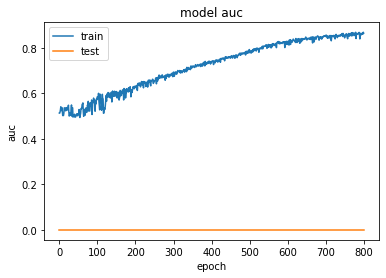

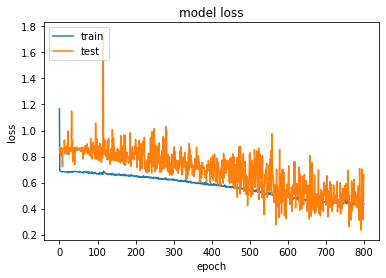

c:\program files\python39\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy Score of Logistic Regression is:  0.7635542168674698
Recall Score of Logistic Regression Model is:  0.097799511002445
Confusion matrix : 
 [[  40  369]
 [ 102 1481]]
Outcome values : 
 40 369 102 1481
Classification report : 
               precision    recall  f1-score   support

           1       0.28      0.10      0.15       409
           0       0.80      0.94      0.86      1583

    accuracy                           0.76      1992
   macro avg       0.54      0.52      0.50      1992
weighted avg       0.69      0.76      0.72      1992

Auc_Score: 0.5166824465940841
AUC: 87.25
Loss: 49.75


In [76]:
from numpy import loadtxt
from sklearn.model_selection import StratifiedKFold
import keras
from keras.models import Sequential
from keras.layers import Dense ,Dropout
from tensorflow.keras import regularizers
# define 10-fold cross validation test harness
# kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
# cvscores = []
# for train, test in kfold.split(X_train_up, y_train_up):
# define the keras model

METRICS = [
#       keras.metrics.TruePositives(name='tp'),
#       keras.metrics.FalsePositives(name='fp'),
#       keras.metrics.TrueNegatives(name='tn'),
#       keras.metrics.FalseNegatives(name='fn'), 
      #keras.metrics.BinaryAccuracy(name='accuracy'),
#      keras.metrics.Precision(name='precision'),
      #keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]
model = Sequential()
model.add(Dense(64, input_dim=46, activation='relu'))
model.add(Dense(32, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(16, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),bias_regularizer=regularizers.l2(1e-4),activity_regularizer=regularizers.l2(1e-5)))
model.add(Dense(16, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),bias_regularizer=regularizers.l2(1e-4),activity_regularizer=regularizers.l2(1e-5)))
#model.add(Dropout(0.2)) 
model.add(Dense(8, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),bias_regularizer=regularizers.l2(1e-4),activity_regularizer=regularizers.l2(1e-5)))
model.add(Dense(4, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),bias_regularizer=regularizers.l2(1e-4),activity_regularizer=regularizers.l2(1e-5)))
model.add(Dense(1, activation='sigmoid'))
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=METRICS)
model.summary()
#class_weight = {0: weight_for_0, 1: weight_for_1}
# fit the keras model on the dataset
history=model.fit(X_train_up, y_train_up, epochs=800, batch_size=200,verbose=0, validation_split=0.15)
# scores_test = model.evaluate(X_train_up[test], y_train_up[test], verbose=0)
# print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
# #cvscores.append(scores_test[1] * 100)
# print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))
# list all data in history
loss, auc = model.evaluate(X_train_up, y_train_up)
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# evaluate the keras model

predictions = model.predict_classes(X_val_fea)
#eval on predictions
print('Accuracy Score of Logistic Regression is: ', accuracy_score(y_val, predictions))
print('Recall Score of Logistic Regression Model is: ', metrics.recall_score(y_val, predictions))
# confusion matrix
matrix_val_nn = confusion_matrix(y_val,predictions, labels=[1,0])
print('Confusion matrix : \n',matrix_val_nn)

# outcome values order in sklearn
tp_val_nn, fn_val_nn, fp_val_nn, tn_val_nn = confusion_matrix(y_val,predictions,labels=[1,0]).reshape(-1)
print('Outcome values : \n', tp_val_nn, fn_val_nn, fp_val_nn, tn_val_nn)

# classification report for precision, recall f1-score and accuracy
matrix_val_cl_nn = classification_report(y_val,predictions,labels=[1,0])
print('Classification report : \n',matrix_val_cl_nn)
#val_auc_score['Logistic Regression'] = roc_auc_score(y_val, test_pred_val_lgr)
print('Auc_Score:',roc_auc_score(y_val, predictions))
print('AUC: %.2f' % (auc*100))
print('Loss: %.2f' % (loss*100))


In [ ]:
prob01_nn_total=model.predict(X_val_fea)
predictions = model.predict_classes(X_val_fea)
flatten_predictions =np.ndarray.flatten(predictions)
flatten_prob =np.ndarray.flatten(prob01_nn_total)

#flatten_prob =np.asarray([item for subl in prob01_nn_total for item in subl])
print(len(flatten_prob))
print(flatten_prob)
#flatten_prob
print(flatten_predictions)
print(len(flatten_predictions))
df1 = pd.DataFrame({'ar1':flatten_prob})
df2 = pd.DataFrame({'ar2':flatten_predictions})
pd.concat([df1.ar1, df2.ar2], axis=1)

In [ ]:
#flatten_predictions =np.asarray([item for subl in predictions for item in subl])
for i in range(len(prob01_nn_total)):
    #print(prob01_nn_total[i])
    if prob01_nn_total[i]>=0.50:
        prob01_nn_total[i]=prob01_nn_total[i]
    else:
        prob01_nn_total[i]=1.0-prob01_nn_total[i]
prob01_nn_total
flatten_prob =np.ndarray.flatten(prob01_nn_total)

#flatten_prob =np.asarray([item for subl in prob01_nn_total for item in subl])
print(len(flatten_prob))
print(flatten_prob)
#flatten_prob
print(flatten_predictions)
print(len(flatten_predictions))
df1 = pd.DataFrame({'ar1':flatten_prob})
df2 = pd.DataFrame({'ar2':flatten_predictions})
pd.concat([df1.ar1, df2.ar2], axis=1)

In [ ]:
pred_nn=X_val_fea.copy()
pred_nn['pred_resp']=flatten_predictions.tolist()
prob01_nn_total=model.predict_proba(X_val_fea)
#prob_nn_total=flatten_prob.tolist()
#prob_scores_promo=xgb3.predict_proba(X_valid_1)
#prob_scores_ho=xgb3.predict_proba(X_valid_0)
#Uplift=prob_scores_promo-prob_scores_ho
#print(prob_nn_total)
pred_nn['prob_scores']= flatten_prob.tolist()
# # print(prob_scores_promo)
# # print(prob_scores_ho)
# # print(Uplift)

pred_nn_1 = pred_nn[pred_nn.treatment == 1]
pred_nn_0 = pred_nn[pred_nn.treatment == 0]
pred_nn['pred_resp'].value_counts()
pred_nn_sort=pred_nn.sort_values(by=['prob_scores'], ascending=False)
pred_nn_1_sort=pred_nn_1.sort_values(by=['prob_scores'], ascending=False)
pred_nn_0_sort=pred_nn_0.sort_values(by=['prob_scores'], ascending=False)
pred_nn_sort['QuantileRank']= pd.qcut(pred_nn_sort['prob_scores'], 
                             q = 5, labels = False)
pred_nn_1_sort['QuantileRank']= pd.qcut(pred_nn_1_sort['prob_scores'], 
                             q = 5, labels = False)
pred_nn_0_sort['QuantileRank']= pd.qcut(pred_nn_0_sort['prob_scores'], 
                             q = 5, labels = False)
pred_nn_sort.head()

In [ ]:
pred_nn_sort['pred_resp'].value_counts()

In [ ]:
total = pred_nn_sort[['pred_resp','QuantileRank']]
promo = pred_nn_1_sort[['pred_resp','QuantileRank']]
ho = pred_nn_0_sort[['pred_resp','QuantileRank']]
total_count_by_quantile = total.groupby('QuantileRank').agg({'pred_resp':('sum','count')}).iloc[::-1]
promo_count_by_quantile = promo.groupby('QuantileRank').agg({'pred_resp':['sum','count']}).iloc[::-1]
ho_count_by_quantile = ho.groupby('QuantileRank').agg({'pred_resp':['sum','count']}).iloc[::-1]
uplift_table = pd.concat([total_count_by_quantile, promo_count_by_quantile, ho_count_by_quantile], axis=1)
uplift_table

In [ ]:
#Convert to numpy arrays
X_train_up, y_train_up = np.array(X_train_up), np.array(y_train_up)

#Reshape the data into 3-D array
X_train_up = np.reshape(X_train_up, (X_train_up.shape[0],X_train_up.shape[1],1))

In [ ]:
import pandas as pd
from torch.utils.data import Dataset
import torch

In [ ]:
# from keras.layers.recurrent import LSTM
# model_lstm = Sequential()
# model_lstm.add(LSTM(20, input_shape=X_train_up.shape[1:], kernel_initializer='lecun_uniform', activation='relu', kernel_regularizer=regularizers.l1(0.1), recurrent_regularizer=regularizers.l1(0.01), bias_regularizer=None, activity_regularizer=None, dropout=0.2, recurrent_dropout=0.2))#, return_sequences=True))
# model_lstm.add(LSTM(12, activation='relu', return_sequences=True))
# #model.add(LSTM(8, activation='relu'))
# model_lstm.add(Dense(1, kernel_initializer='lecun_uniform', activation='sigmoid'))

# model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) #optimizer='rmsprop'
# print(model_lstm.summary())

# history_lstm=model_lstm.fit(X_train_up, y_train_up, epochs=200, batch_size=10000, class_weight={0 : 1., 1: float(int(1/np.mean(y_train_up)))}, validation_split=0.2)
# loss, auc = model.evaluate(X_train_up, y_train_up)
# print(history.history.keys())
# # summarize history for accuracy
# plt.plot(history_lstm.history_lstm['auc'])
# plt.plot(history_lstm.history_lstm['val_auc'])
# plt.title('model auc')
# plt.ylabel('auc')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()
# # summarize history for loss
# plt.plot(history_lstm.history_lstm['loss'])
# plt.plot(history_lstm.history_lstm['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()
# # evaluate the keras model

# predictions_lstm = model_lstm.predict_classes(X_val_fea)
# #eval on predictions
# print('Accuracy Score of Logistic Regression is: ', accuracy_score(y_val, predictions_lstm))
# print('Recall Score of Logistic Regression Model is: ', metrics.recall_score(y_val, predictions_lstm))
# # confusion matrix
# matrix_val_lstm = confusion_matrix(y_val,predictions_lstm, labels=[1,0])
# print('Confusion matrix : \n',matrix_val_nn)

# # outcome values order in sklearn
# tp_val_lstm, fn_val_lstm, fp_val_lstm, tn_val_lstm = confusion_matrix(y_val,predictions_lstm,labels=[1,0]).reshape(-1)
# print('Outcome values : \n', tp_val_lstm, fn_val_lstm, fp_val_lstm, tn_val_lstm)

# # classification report for precision, recall f1-score and accuracy
# matrix_val_cl_lstm = classification_report(y_val,predictions_lstm,labels=[1,0])
# print('Classification report : \n',matrix_val_cl_lstm)
# #val_auc_score['Logistic Regression'] = roc_auc_score(y_val, test_pred_val_lgr)
# print('Auc_Score:',roc_auc_score(y_val, predictions_lstm))
# print('AUC: %.2f' % (auc*100))
# print('Loss: %.2f' % (loss*100))

# hi